In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
import h5py
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import json
import glob
import re

Define functions to calculate $\chi_\mathrm{eff}$ and $\chi_p$:

In [2]:
def Calculate_Xp(m1, m2, a1, a2, costilt1, costilt2):

    # Mass ratio 
    q = 1.0*m1/m2

    # Coefficients A1 and A2 
    A1 = 2 + 3/(2*q)
    A2 = 2 + 3*q/2

    # Calculating sin from cos
    sintilt1 = np.sqrt(1-(costilt1)**2)
    sintilt2 = np.sqrt(1-(costilt2)**2)

    # Terms in Xp
    term1 = A1*a1*(m1**2)*sintilt1
    term2 = A2*a2*(m2**2)*sintilt2
    coeff = 1.0/(2*A1*(m1**2))

    # Using addition of terms method 
    Xp = coeff*(term1 + term2 + np.abs(term1 - term2))

    return Xp

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

def eta(m1,m2):
    return m1*m2/(m1+m2)/(m1+m2)

def Mc(m1,m2):
    return np.power(eta(m1,m2),3./5.)*(m1+m2)

We'll additionally be reweighting the default LALInference mass and redshift priors with more astrophysically-motivated priors. The LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(m_1,m_2,z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$.

We'll reweight to a prior that assumes the (source-frame) comoving merger rate density evolves as $(1+z)^{2.7}$, and a mass prior that takes the form of a power law on $m_1$ and $q$ (once conditioned on the primary mass):

\begin{equation}
p_\mathrm{astro}(m_1,m_2,z) \propto \frac{1}{1+z} \left(1+z\right)^{2.7} \frac{dV_c}{dz} \,m_1^{-2.2}\,q^{1.3}
\end{equation}

In [3]:
c = 3.0e8          # m/s
H_0 = 67270.0      # m/s/MPc
Omega_M = 0.3156 # unitless
Omega_Lambda = 1.0-Omega_M

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl, m1, m2):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    
    pz = np.power(1.+z,2.7-1.)*dVc_dz
    
    alpha = -2.2
    beta = 1.3
    mMin = 5.
    mMax = 75.
    
    pm1 = np.power(m1/(1.+z),alpha) #m1 and m2 are presumed to be in the **detector frame**
    pm2 = np.power(m2/(1.+z),beta)/(np.power(m1/(1.+z),1.+beta)-np.power(mMin,1.+beta))
    
    pASTRO = pz*pm1*pm2
    pASTRO[m2/(1.+z)<mMin] = 0.
    pASTRO[m1/(1.+z)>mMax] = 0.
    
    return pASTRO

For later use, we'll want to build an interpolant between luminosity distance and redshift:

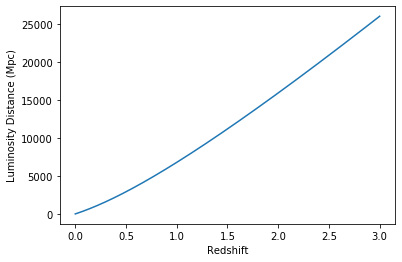

In [4]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = Planck15.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Mpc)')
plt.show()

Next, define a function to build chi-effective and chi-p priors. For every event below, we'll define a dictionary containing the mass bounds used for the given event's PE

In [5]:
def drawPriorSamples(nsamps,q,massSamps=False):
    
    m1_prior = 100.*np.ones(nsamps)
    m2_prior = q*m1_prior

    # Draw spin magnitudes and tilt angles
    a1_prior = np.random.random(nsamps)
    a2_prior = np.random.random(nsamps)
    cost1_prior = 2.*np.random.random(nsamps)-1
    cost2_prior = 2.*np.random.random(nsamps)-1

    # Compute and return effective spins
    xeff_prior = Calculate_Xeff(m1_prior,m2_prior,a1_prior,a2_prior,cost1_prior,cost2_prior)
    xp_prior = Calculate_Xp(m1_prior,m2_prior,a1_prior,a2_prior,cost1_prior,cost2_prior)
    
    if massSamps==True:
        return xeff_prior,xp_prior,m1_prior,m2_prior
    
    else:
        return xeff_prior,xp_prior

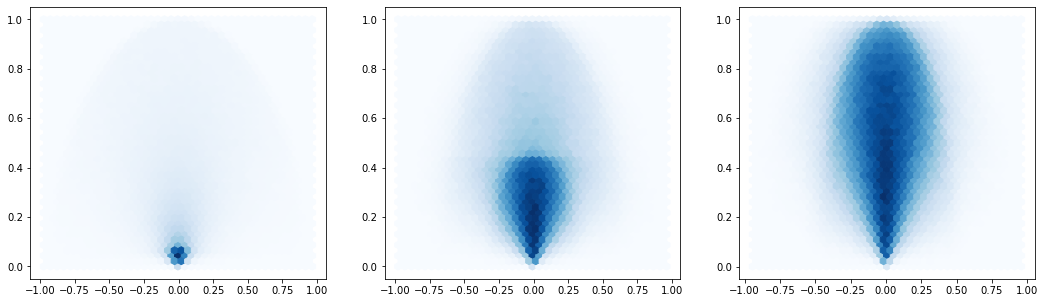

In [6]:
xeff_01,xp_01 = drawPriorSamples(1000000,0.1)
xeff_05,xp_05 = drawPriorSamples(1000000,0.5)
xeff_10,xp_10 = drawPriorSamples(1000000,1.0)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
ax.hexbin(xeff_01,xp_01,cmap='Blues',gridsize=40)
ax = fig.add_subplot(132)
ax.hexbin(xeff_05,xp_05,cmap='Blues',gridsize=40)
ax = fig.add_subplot(133)
ax.hexbin(xeff_10,xp_10,cmap='Blues',gridsize=40)
plt.show()

Now define a function that takes generated prior samples and builds approximants to the chi-effective, chi-p, and joint spin priors. Specifically, we'll generate KDEs in all three spaces, then use the KDEs to build spline interpolants of each prior.

As we'll see below, near $\chi_p = 0$ the $\chi_\mathrm{eff}$ prior is an extremely narrow ridge. To help us resolve this ridge with our KDE, when building the joint prior we'll work with $\mathrm{logistic}(\chi_\mathrm{eff})$:

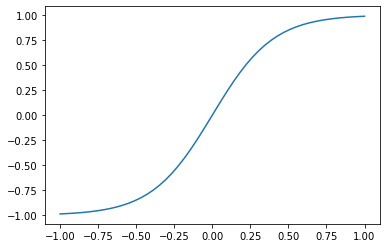

In [6]:
# Logistic transform:
def logistic(x):
    return 2./(1.+np.exp(-5.*x))-1
    
x = np.linspace(-1,1)
plt.plot(x,logistic(x))
plt.show()

Our interpolant builder:

In [7]:
def buildInterpolants(xeff_prior_samps,xp_prior_samps,demo=False):
    
    # Construct Gaussian KDEs of 1D and 2D priors:
    xeff_prior_kde = gaussian_kde(xeff_prior_samps)
    xp_prior_kde = gaussian_kde(xp_prior_samps)
    #joint_prior_kde = gaussian_kde(np.array([xeff_prior_samps,xp_prior_samps]))
    joint_prior_kde = gaussian_kde(np.array([logistic(xeff_prior_samps),xp_prior_samps]),
                                   bw_method=0.5*xeff_prior_samps.size**(-1./6.))
    
    # Chi-Eff prior interpolant
    chi_effs_to_interp = np.concatenate(([-1],np.arange(-0.99,1.,0.01),[1]))
    prob_chi_effs_to_interp = np.concatenate(([0.],xeff_prior_kde(np.arange(-0.99,1.,0.01)),[0]))
    chi_eff_norm = np.trapz(prob_chi_effs_to_interp,chi_effs_to_interp)
    chiEff_interp_function = interp1d(chi_effs_to_interp,prob_chi_effs_to_interp/chi_eff_norm,kind='cubic')

    # Chi-P prior interpolant
    chi_ps_to_interp = np.concatenate(([0],np.arange(0.02,1.0,0.02),[0.99],[1]))
    prob_chi_ps_to_interp = np.concatenate(([0],xp_prior_kde(np.arange(0.02,1.,0.02)),xp_prior_kde(0.99),[0]))
    chip_norm = np.trapz(prob_chi_ps_to_interp,chi_ps_to_interp)
    chip_interp_function = interp1d(chi_ps_to_interp,prob_chi_ps_to_interp/chip_norm,kind='cubic')
    
    # Construct XY grid for joint prior interpolater, add zeros around the edges
    x_input = np.concatenate([np.arange(-1.,-0.2,0.1),np.arange(-0.2,0.2,0.02),np.arange(0.2,1.1,0.1)])
    y_input = np.concatenate([[0.],np.arange(0.02,0.1,0.01),np.arange(0.1,1.05,0.05)])
    X,Y = np.meshgrid(x_input,y_input)
    zs = joint_prior_kde([X.reshape(-1),Y.reshape(-1)])
    zs_2d = zs.reshape(y_input.size,x_input.size)
    zs_2d[0,:] = 0.
    zs_2d[-1,:] = 0.
    zs_2d[:,0] = 0.
    zs_2d[:,-1] = 0.
    jointPriorSpline = RectBivariateSpline(x_input,y_input,zs_2d.T,kx=2,ky=2)
    
    if demo==True:
        return chiEff_interp_function,chip_interp_function,jointPriorSpline,x_input,y_input,zs_2d
    
    else:
        return chiEff_interp_function,chip_interp_function,jointPriorSpline
    
# For convenience, define a function that will move samples to the logistic domain, interpolate,
# and apply the appropriate Jacobian factor
def evaluateJointPrior(chiEff_samps,chiP_samps,joint_spline):
    joint_priors_lx = joint_spline.ev(logistic(chiEff_samps),chiP_samps)
    joint_priors = joint_priors_lx*(2.*5.*np.exp(-5.*chiEff_samps))/np.square(1.+np.exp(-5.*chiEff_samps))
    return joint_priors

Demonstration:

In [9]:
# Draw samples and get resulting interpolants
xeff_prior_samps,xp_prior_samps = drawPriorSamples(1000000,0.8)
chiEff_interp,chip_interp,joint_spline,demo_x,demo_y,demo_z = buildInterpolants(xeff_prior_samps,xp_prior_samps,demo=True)

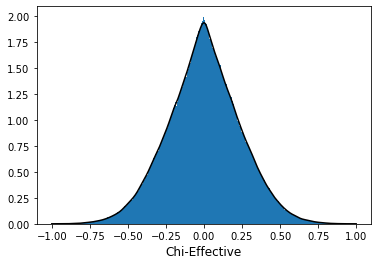

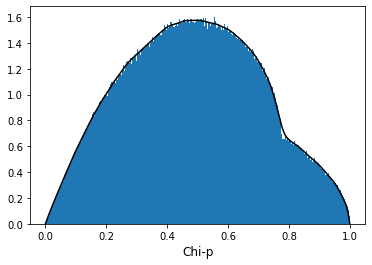

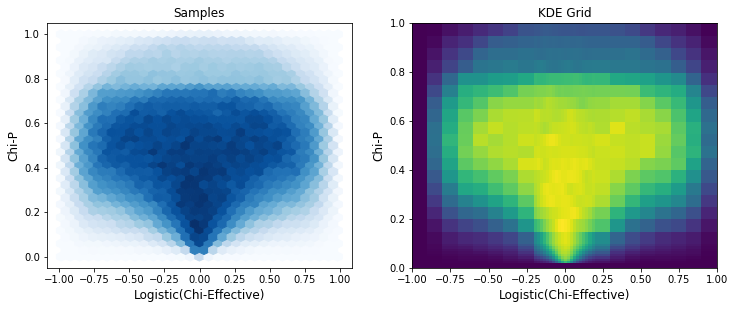

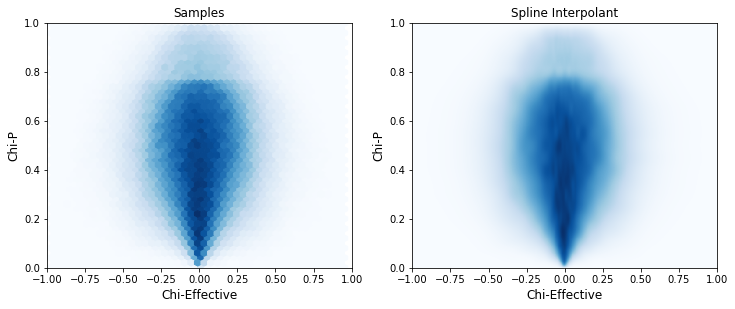

In [10]:
# Plot chi-effective samples and interpolant
fig, ax = plt.subplots()
ax.hist(xeff_prior_samps,bins=300,density=True)
ax.plot(np.linspace(-1.,1.,300),chiEff_interp(np.linspace(-1.,1.,300)),color='black')
ax.set_xlabel('Chi-Effective',fontsize=12)
plt.show()

# Plot chi-p samples and interpolant
fig, ax = plt.subplots()
n,bins,patches = ax.hist(xp_prior_samps,bins=300,density=True)
ax.plot(np.linspace(0.,1.,300),chip_interp(np.linspace(0.,1.,300)),color='black')
ax.set_xlabel('Chi-p',fontsize=12)
plt.show()

# Our joint KDE and interpolant in logistic space
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121)
ax.hexbin(logistic(xeff_prior_samps),xp_prior_samps,gridsize=30,cmap='Blues')
ax.set_xlabel('Logistic(Chi-Effective)',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('Samples',fontsize=12)

ax = fig.add_subplot(122)
ax.pcolormesh(demo_x,demo_y,demo_z)
ax.set_xlabel('Logistic(Chi-Effective)',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('KDE Grid',fontsize=12)

# Our joint prior moved back to chi-effective space
fig = plt.figure(figsize=(12,4.5))
ax = fig.add_subplot(121)
ax.hexbin(xeff_prior_samps,xp_prior_samps,gridsize=45,cmap='Blues')
ax.set_xlabel('Chi-Effective',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)
ax.set_title('Samples',fontsize=12)

ax = fig.add_subplot(122)
demo_grid_x = np.linspace(-1,1,1000)
demo_grid_y = np.linspace(0,1,1010)
X,Y = np.meshgrid(demo_grid_x,demo_grid_y)
demo_output = evaluateJointPrior(X.reshape(-1),Y.reshape(-1),joint_spline)
plt.pcolormesh(demo_grid_x,demo_grid_y,demo_output.reshape(demo_grid_y.size,demo_grid_x.size),cmap='Blues')
ax.set_xlabel('Chi-Effective',fontsize=12)
ax.set_ylabel('Chi-P',fontsize=12)
ax.set_title('Spline Interpolant',fontsize=12)

plt.show()

Let's look a little closer at the 1D priors:

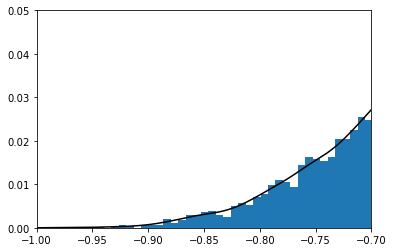

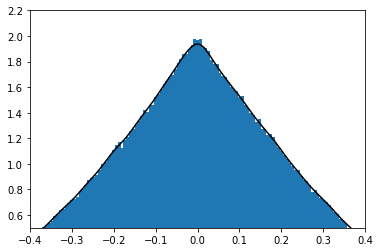

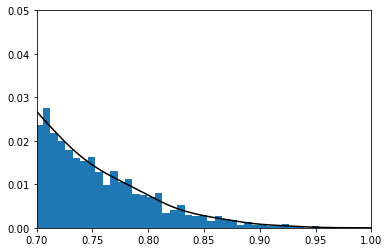

In [11]:
fig, ax = plt.subplots()
n,bins,patches = ax.hist(xeff_prior_samps,bins=np.linspace(-1.,1.,300),density=True)
ax.plot(np.linspace(-1.,1.,1000),chiEff_interp(np.linspace(-1.,1.,1000)),color='black')
ax.set_xlim(-1.,-0.7)
ax.set_ylim(0.,0.05)
plt.show()

fig, ax = plt.subplots()
n,bins,patches = ax.hist(xeff_prior_samps,bins=np.linspace(-1.,1.,300),density=True)
ax.plot(np.linspace(-1.,1.,1000),chiEff_interp(np.linspace(-1.,1.,1000)),color='black')
ax.set_xlim(-0.4,0.4)
ax.set_ylim(0.5,2.2)
plt.show()

fig, ax = plt.subplots()
n,bins,patches = ax.hist(xeff_prior_samps,bins=np.linspace(-1.,1.,300),density=True)
ax.plot(np.linspace(-1.,1.,1000),chiEff_interp(np.linspace(-1.,1.,1000)),color='black')
ax.set_xlim(0.7,1.)
ax.set_ylim(0.,0.05)
plt.show()

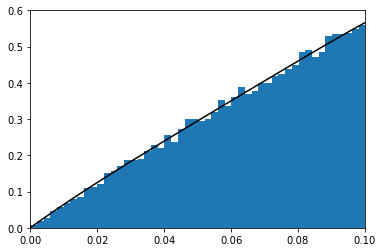

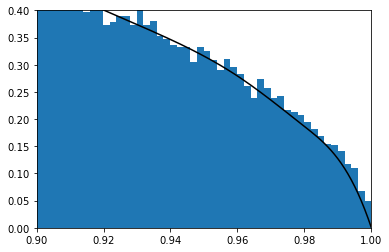

In [12]:
fig, ax = plt.subplots()
n,bins,patches = ax.hist(xp_prior_samps,bins=np.linspace(0.,1.,500),density=True)
#ax.scatter(chi_ps_to_interp,prob_chi_ps_to_interp,marker='x',color='black',s=30,zorder=10)
ax.plot(np.linspace(0.,1.,1000),chip_interp(np.linspace(0.,1.,1000)),color='black')
ax.set_xlim(0.,0.1)
ax.set_ylim(0.,0.6)
plt.show()

fig, ax = plt.subplots()
n,bins,patches = ax.hist(xp_prior_samps,bins=np.linspace(0.,1.,500),density=True)
#ax.scatter(chi_ps_to_interp,prob_chi_ps_to_interp,marker='x',color='black',s=30,zorder=10)
ax.plot(np.linspace(0.,1.,1000),chip_interp(np.linspace(0.,1.,1000)),color='black')
ax.set_xlim(0.9,1.)
ax.set_ylim(0.,0.4)
plt.show()

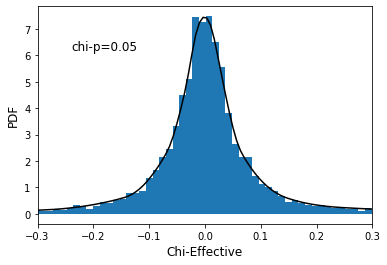

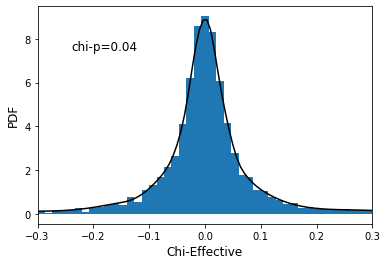

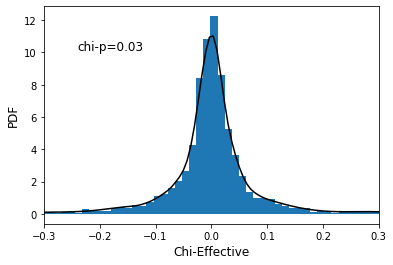

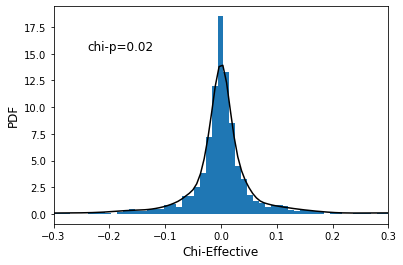

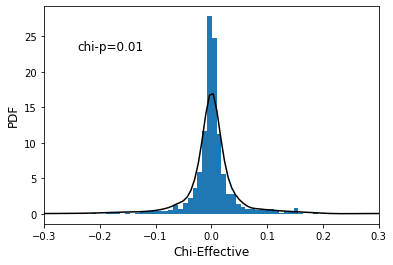

In [13]:
for chi_p in [0.05,0.04,0.03,0.02,0.01]:

    chieffs = np.linspace(-1.,1.,300)    
    marginal_prior = evaluateJointPrior(chieffs,chi_p*np.ones(chieffs.size),joint_spline)   
    marginal_prior /= np.trapz(marginal_prior,chieffs)

    fig,ax = plt.subplots()
    plt.hist(xeff_prior_samps[(xp_prior_samps<=chi_p+0.01)*(xp_prior_samps>=chi_p-0.01)],bins=100,density=True)
    ax.plot(chieffs,marginal_prior,color='black')
    ax.set_xlim(-0.3,0.3)
    ax.set_xlabel('Chi-Effective',fontsize=12)
    ax.set_ylabel('PDF',fontsize=12)
    ax.text(0.1,0.8,'chi-p={0}'.format(chi_p),transform=ax.transAxes,fontsize=12)
    plt.show()

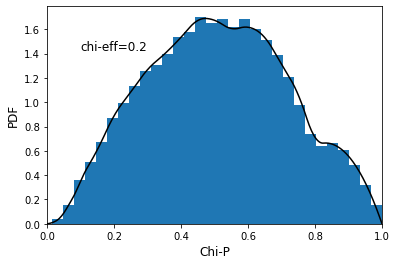

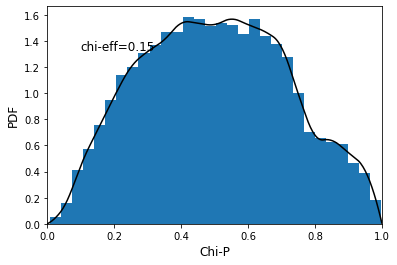

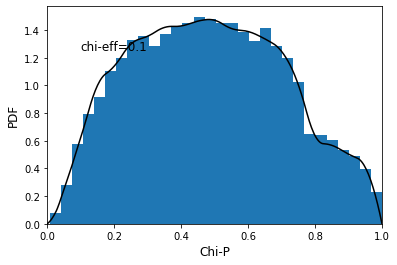

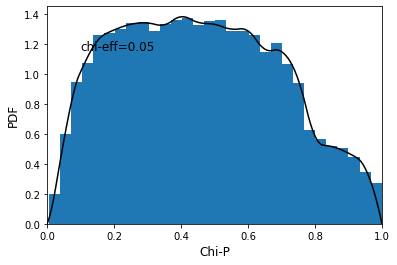

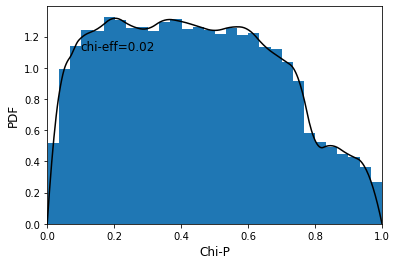

In [16]:
for chieff in [0.2,0.15,0.10,0.05,0.02]:

    chips = np.linspace(0.,1.,300)
    marginal_prior = evaluateJointPrior(chieff*np.ones(chips.size),chips,joint_spline)
    marginal_prior /= np.trapz(marginal_prior,chips)

    fig,ax = plt.subplots()
    plt.hist(xp_prior_samps[(xeff_prior_samps<=chieff+0.01)*(xeff_prior_samps>=chieff-0.01)],bins=30,density=True)
    ax.plot(chips,marginal_prior,color='black')
    ax.set_xlim(0,1)
    ax.set_xlabel('Chi-P',fontsize=12)
    ax.set_ylabel('PDF',fontsize=12)
    ax.text(0.1,0.8,'chi-eff={0}'.format(chieff),transform=ax.transAxes,fontsize=12)
    plt.show()

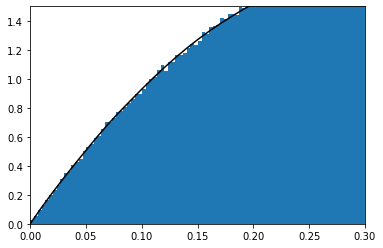

In [33]:
demo_integral = np.mean(joint_spline(np.arange(-1.,1.,0.01),np.arange(0.,1.0,0.01)),axis=0)
demo_integral /= np.trapz(demo_integral,np.arange(0.,1.,0.01))

fig,ax = plt.subplots()
plt.hist(xp_prior_samps,bins=300,density=True)
plt.plot(np.arange(0.,1,0.01),demo_integral,color='black')
ax.set_xlim(0.,.3)
ax.set_ylim(0.,1.5)
plt.show()

In [14]:
reference_qs = np.linspace(0.01,1.0,40)
reference_splines = []
reference_chiEff_interps = []
reference_chiP_interps = []
for ref_q in reference_qs:
    print(ref_q)
    
    xeff_prior_samps,xp_prior_samps = drawPriorSamples(1000000,ref_q)
    chiEff_interp_function,chip_interp_function,jointPriorSpline = buildInterpolants(xeff_prior_samps,xp_prior_samps)
    reference_splines.append(jointPriorSpline)
    reference_chiEff_interps.append(chiEff_interp_function)
    reference_chiP_interps.append(chip_interp_function)
    
np.save('./preprocessed-single-events-qGrid/priors.npy',\
        np.array([reference_qs,reference_splines,reference_chiEff_interps,reference_chiP_interps]))

0.01
0.03538461538461538


KeyboardInterrupt: 

In [8]:
reference_qs,reference_splines,reference_chiEff_interps,reference_chiP_interps = np.load('./preprocessed-single-events-qGrid/priors.npy',\
                                                                                        allow_pickle=True)

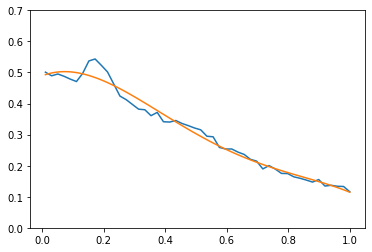

In [9]:
ps = [evaluateJointPrior(0.3,0.1,spline) for spline in reference_splines]
x = np.linspace(0.01,1.,100)
test = UnivariateSpline(reference_qs,ps,k=4,s=0.1)

fig,ax = plt.subplots()
ax.plot(reference_qs,ps)
ax.set_ylim(0,0.7)
ax.plot(x,test(x))

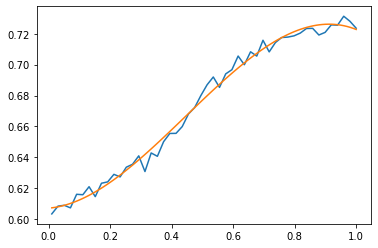

In [17]:
ps = [interp(0.3) for interp in reference_chiEff_interps]
x = np.linspace(0.01,1.,100)
test = UnivariateSpline(reference_qs,ps,k=3,s=0.1)

plt.plot(reference_qs,ps)
plt.plot(x,test(x))

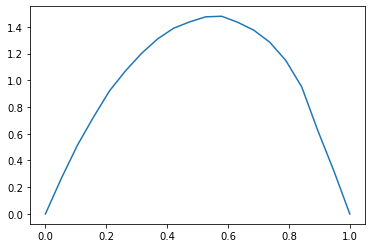

In [14]:
chiPs = np.linspace(0,1.,20)
ps = np.array([])
for chiP in chiPs:
    ps = np.append(ps,reference_chiP_interps[-5](chiP))
    
plt.plot(chiPs,ps)

In [17]:
O1O2_events = ['GW151012', 'GW170608', 'GW170729', 'GW151226', 'GW170814', 'GW150914', 'GW170104', 'GW170809', 'GW170818', 'GW170823']
for key in O1O2_events:
    
    print("##### {0}".format(key))
    
    # load samples
    BBH_post = h5py.File('./Input/GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']
    
    # Downselect to a reasonable number of samples
    nSamps = min(5000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_DF/m1_DF
    
    joint_priors = np.zeros(q.size)
    Xeff_priors = np.zeros(q.size)
    Xp_priors = np.zeros(q.size)
    for i in range(q.size):
        
        ref_joint_ps = [evaluateJointPrior(Xeff[i],Xp[i],spline) for spline in reference_splines]
        joint = UnivariateSpline(reference_qs,ref_joint_ps,k=3,s=0.1)
        joint_priors[i] = joint(q[i])
        
        ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        Xeff_priors[i] = xeff_1d(q[i])
        
        ref_xp_ps = [interp(Xp[i]) for interp in reference_chiP_interps]
        xp_1d = UnivariateSpline(reference_qs,ref_xp_ps,k=3,s=0.1)
        Xp_priors[i] = xp_1d(q[i])

    # Redshift and mass priors
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_DF,m2_DF)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    print(Xp_priors[Xp_priors<0])
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z),\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-sampleRelease/{0}.npy'.format(key),preprocDict)

##### GW151012
[]
##### GW170608
[]
##### GW170729
[]
##### GW151226
[]
##### GW170814
[]
##### GW150914
[]
##### GW170104
[]
##### GW170809
[]
##### GW170818
[]
##### GW170823
[]


In [18]:
O3_events = [
'S190408an',
'S190412m',
'S190413ac',
'S190413i',
'S190421ar',
'S190424ao',
'S190503bf',
'S190512at',
'S190513bm',
'S190514n',
'S190517h',
'S190519bj',
'S190521g',
'S190521r',
'S190527w',
'S190602aq',
'S190620e',
'S190630ag',
'S190701ah',
'S190706ai',
'S190707q',
'S190708ap',
'S190720a',
'S190727h',
'S190728q',
'S190731aa',
'S190803e',
'S190828j',
'S190828l',
'S190910s',
'S190915ak',
'S190924h',
'S190929d',
'S190930s']

In [25]:
sampleRelease = "/home/john.veitch/o3a_catalog_events/o3a_pe_samples_release"
for key in O3_events:
    
    print(key)
        
    # Load samples
    f = h5py.File('{0}/{1}.h5'.format(sampleRelease,key),'r')
    BBH_post_samples = f['PrecessingSpinIMRHM']['posterior_samples']

    m1_SF = np.squeeze(BBH_post_samples['mass_1_source'])
    m2_SF = np.squeeze(BBH_post_samples['mass_2_source'])
    a1 = np.squeeze(BBH_post_samples['a_1'])
    a2 = np.squeeze(BBH_post_samples['a_2'])
    cost1 = np.squeeze(BBH_post_samples['cos_tilt_1'])
    cost2 = np.squeeze(BBH_post_samples['cos_tilt_2'])
    DL = np.squeeze(BBH_post_samples['luminosity_distance'])
    z = np.squeeze(BBH_post_samples['redshift'])

    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)

    f.close()          
            
    # Downselect to a reasonable number of samples
    nSamps = min(5000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    joint_priors = np.zeros(q.size)
    Xeff_priors = np.zeros(q.size)
    Xp_priors = np.zeros(q.size)
    for i in range(q.size):
        
        ref_joint_ps = [evaluateJointPrior(Xeff[i],Xp[i],spline) for spline in reference_splines]
        joint = UnivariateSpline(reference_qs,ref_joint_ps,k=3,s=0.1)
        joint_priors[i] = joint(q[i])
        
        ref_xeff_ps = [interp(Xeff[i]) for interp in reference_chiEff_interps]
        xeff_1d = UnivariateSpline(reference_qs,ref_xeff_ps,k=3,s=0.1)
        Xeff_priors[i] = xeff_1d(q[i])
        
        ref_xp_ps = [interp(Xp[i]) for interp in reference_chiP_interps]
        xp_1d = UnivariateSpline(reference_qs,ref_xp_ps,k=3,s=0.1)
        Xp_priors[i] = xp_1d(q[i])

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_SF*(1+z),m2_SF*(1+z))
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    print(Xp_priors[Xp_priors<0])    
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF,\
                        'a1':a1,\
                        'a2':a2,\
                        'cost1':cost1,\
                        'cost2':cost2
                       }
    np.save('preprocessed-single-events-sampleRelease/{0}.npy'.format(key),preprocDict)

S190408an
[]
S190412m
[]
S190413ac
[]
S190413i
[]
S190421ar
[]
S190424ao
[]
S190503bf
[]
S190512at
[]
S190513bm
[]
S190514n
[]
S190517h
[]
S190519bj
[]
S190521g
[]
S190521r
[]
S190527w
[]
S190602aq
[]
S190620e
[]
S190630ag
[]
S190701ah
[]
S190706ai
[]
S190707q
[]
S190708ap
[]
S190720a
[]
S190727h
[]
S190728q
[]
S190731aa
[]
S190803e
[]
S190828j
[]
S190828l
[]
S190910s
[]
S190915ak
[]
S190924h
[]
S190929d
[]
S190930s
[]


In [26]:
sampleDict = {}
singleEvents = glob.glob('./preprocessed-single-events-sampleRelease/*')
for eventFile in singleEvents:
    
    if eventFile=="./preprocessed-single-events-sampleRelease/priors.npy":
        continue
    
    key = re.split('\/|\.',eventFile)[-2]
    dataDict = np.load(eventFile,allow_pickle=True)[()]
    sampleDict[key] = dataDict

import pickle
with open('sampleDict_sampleRelease.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

---
# Old

In [8]:
priorBoundsO1O2 = {
    'GW150914':{'m_min':10.,'m_max':80.,'q_min':0.,'q_max':1,'mc_min':0.,'mc_max':200},
    'GW151012':{'m_min':3.,'m_max':100.,'q_min':0.055555555555,'q_max':1,'mc_min':10.,'mc_max':30.},
    'GW151226':{'m_min':3.022,'m_max':54.398,'q_min':0.0555555555555556,'q_max':1,'mc_min':9.5,'mc_max':10.5},
    'GW170104':{'m_min':5.48137020001,'m_max':160.434221217,'q_min':0.125,'q_max':1,'mc_min':12.299703,'mc_max':45.0},
    'GW170608':{'m_min':1.,'m_max':40.,'q_min':0.1,'q_max':1,'mc_min':8.,'mc_max':9.},
    'GW170729':{'m_min':10.,'m_max':200.,'q_min':0.125,'q_max':1,'mc_min':0.,'mc_max':200.},
    'GW170809':{'m_min':5.48137020001,'m_max':160.434221217,'q_min':0.125,'q_max':1,'mc_min':12.299703,'mc_max':45.,'mtotal_min':25.,'mtotal_max':100},
    'GW170814':{'m_min':5.48137020001,'m_max':160.434221217,'q_min':0.125,'q_max':1,'mc_min':12.299703,'mc_max':45.},
    'GW170818':{'m_min':5.48137020001,'m_max':160.434221217,'q_min':0.125,'q_max':1,'mc_min':12.299703,'mc_max':45.},
    'GW170823':{'m_min':5.48137020001,'m_max':160.434221217,'q_min':0.125,'q_max':1,'mc_min':12.299703,'mc_max':55.},
}

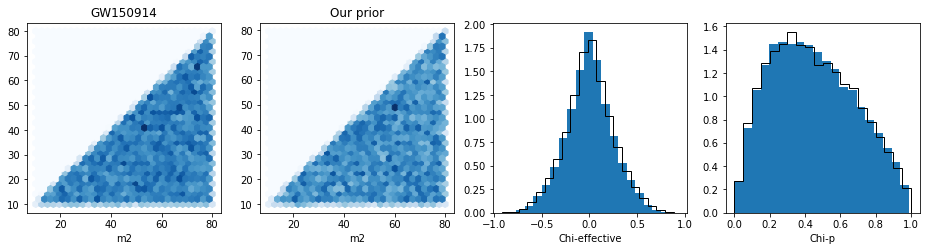

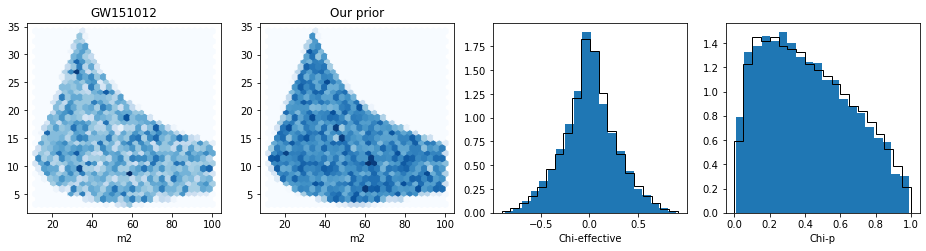

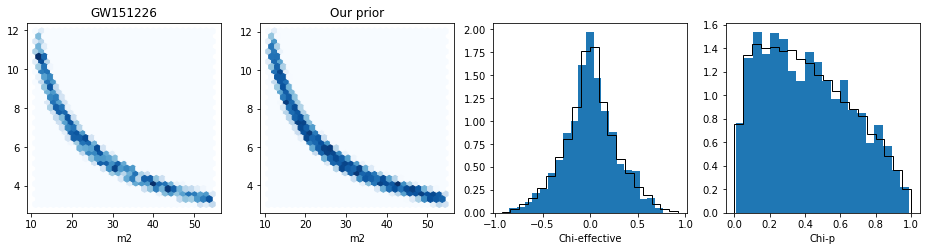

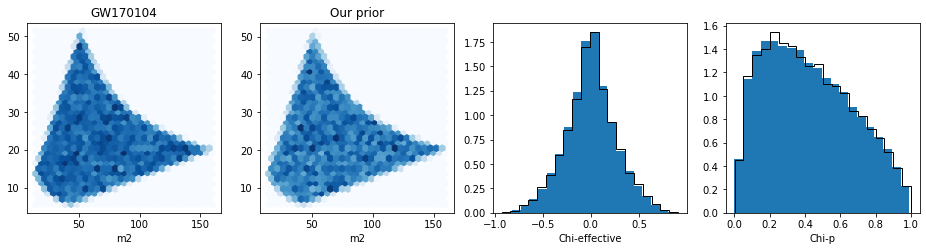

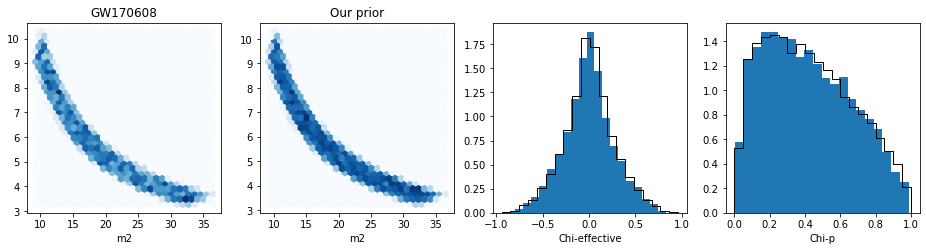

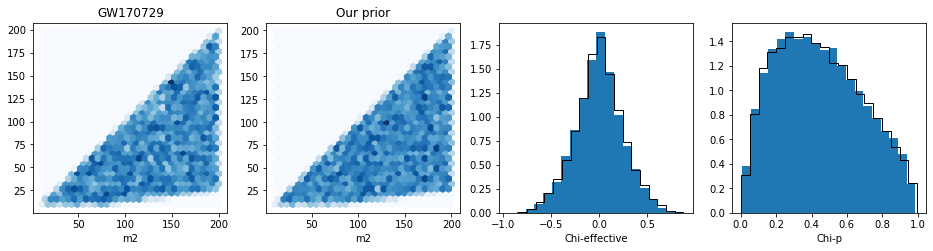

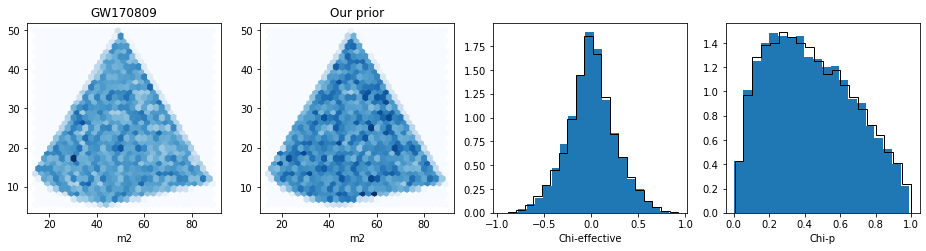

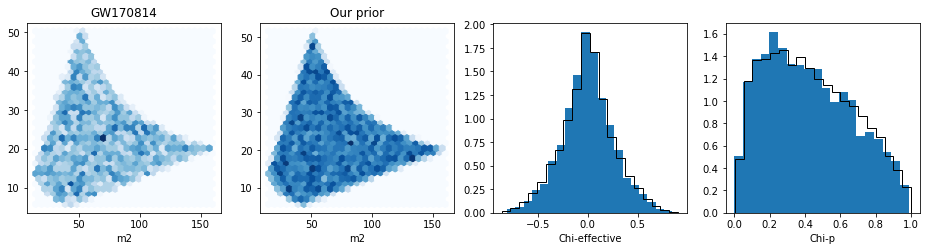

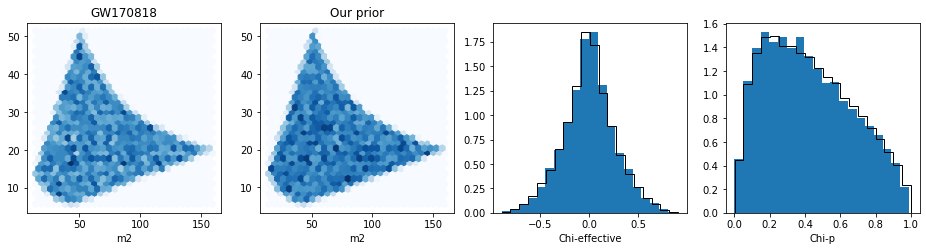

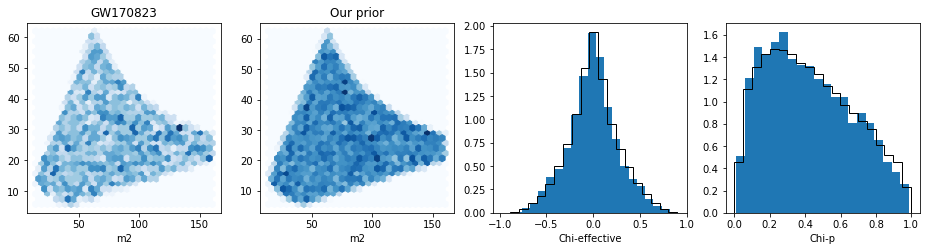

In [14]:
for key in priorBoundsO1O2:

    h5 = h5py.File("GWTC-1_sample_release/{0}_GWTC-1.hdf5".format(key))
    m1 = np.asarray(h5['prior'])['m1_detector_frame_Msun']
    m2 = np.asarray(h5['prior'])['m2_detector_frame_Msun']
    a1 = np.asarray(h5['prior'])['spin1']
    a2 = np.asarray(h5['prior'])['spin2']
    cost1 = np.asarray(h5['prior'])['costilt1']
    cost2 = np.asarray(h5['prior'])['costilt2']
    
    fig = plt.figure(figsize=(16,3.5))
    ax = fig.add_subplot(141)
    ax.hexbin(m1,m2,cmap='Blues',gridsize=30)
    ax.set_xlabel('m1')
    ax.set_xlabel('m2')
    ax.set_title(key)
    
    ax = fig.add_subplot(142)   
    xeff_prior,xp_prior,m1_prior,m2_prior = drawPriorSamples(20000,priorBoundsO1O2[key],massSamps=True)
    ax.hexbin(m1_prior,m2_prior,cmap='Blues',gridsize=30)
    ax.set_xlabel('m1')
    ax.set_xlabel('m2')
    ax.set_title('Our prior')
    
    ax = fig.add_subplot(143)
    ax.hist(Calculate_Xeff(m1,m2,a1,a2,cost1,cost2),bins=20,histtype='stepfilled',density=True)
    ax.hist(xeff_prior,bins=20,histtype='step',density=True,color='black')
    ax.set_xlabel('Chi-effective')
    
    ax = fig.add_subplot(144)
    ax.hist(Calculate_Xp(m1,m2,a1,a2,cost1,cost2),bins=20,histtype='stepfilled',density=True)
    ax.hist(xp_prior,bins=20,histtype='step',density=True,color='black')
    ax.set_xlabel('Chi-p')
    
    plt.show()
    h5.close()

Initialize a dictionary to hold pre-processed samples:

In [9]:
sampleDict = {}
referenceSamples = np.load('sampleDict_shanika_2020-03-30.pickle',allow_pickle=True)

Loop across O1 and O2 events. We'll want to compute and store:
* Chi-effective posterior
* Chi-p posterior
* Chi-effective prior evaluated at posterior values
* Chi-p prior evaluated at posterior values
* Weights used to convert from LALInference to astrophysical mass/redshift priors

##### GW150914


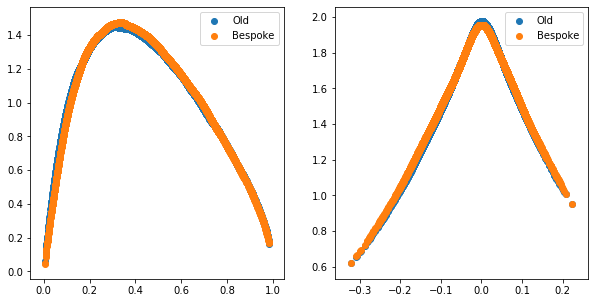

##### GW151012


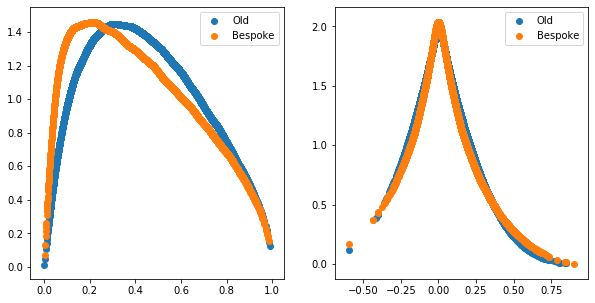

##### GW151226


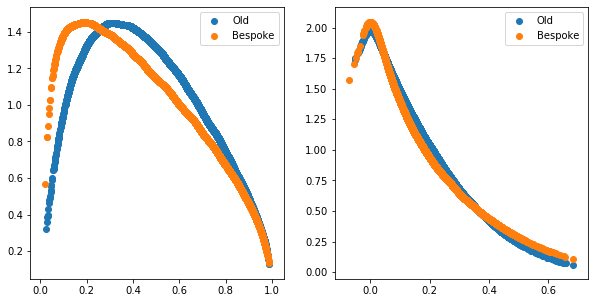

##### GW170104


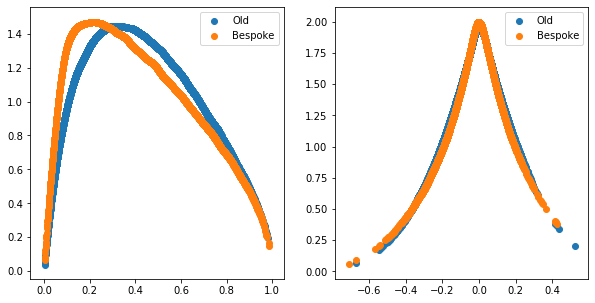

##### GW170608


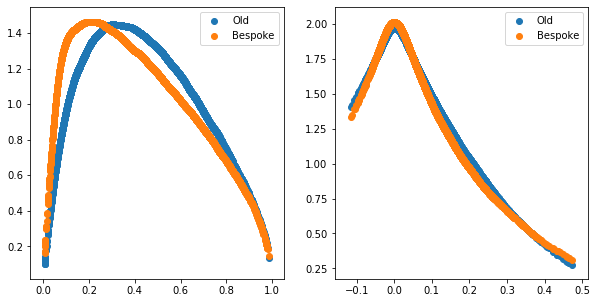

##### GW170729


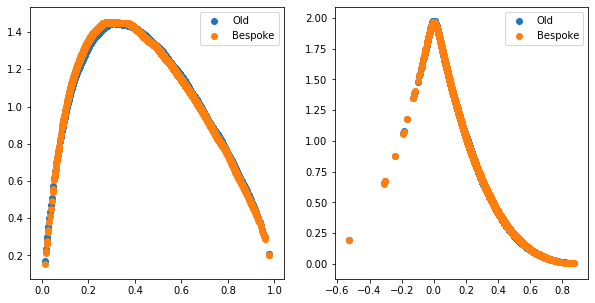

##### GW170809


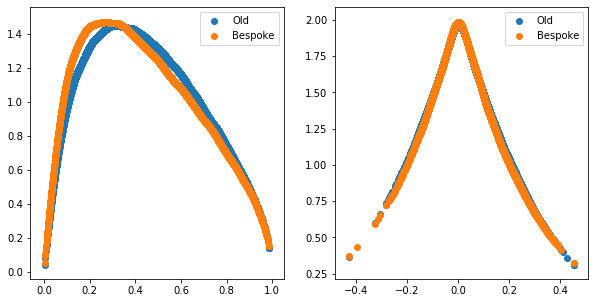

##### GW170814


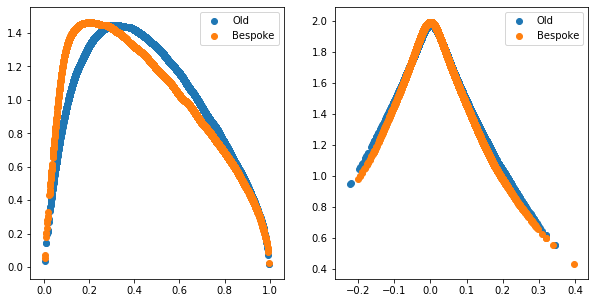

##### GW170818


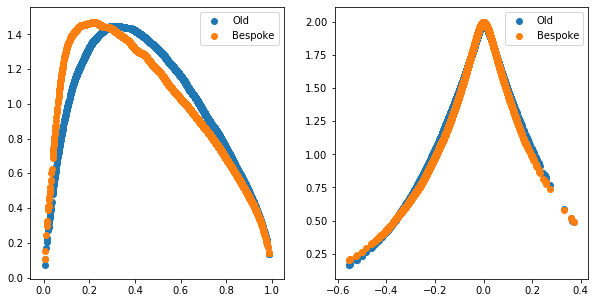

##### GW170823


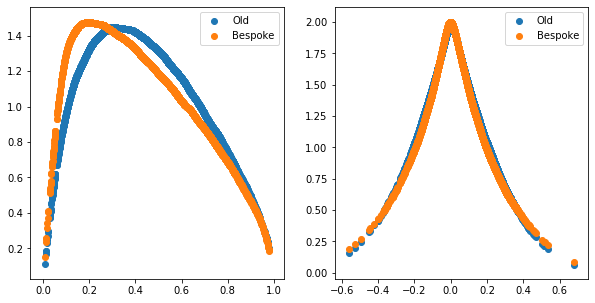

In [10]:
for key in priorBoundsO1O2:
    
    print("##### {0}".format(key))

    xeff_prior_samps,xp_prior_samps = drawPriorSamples(1000000,priorBoundsO1O2[key])
    chiEff_interp_function,chip_interp_function,jointPriorSpline = buildInterpolants(xeff_prior_samps,xp_prior_samps)
    #chiEff_interp_function = chiEff_interp
    #chip_interp_function = chip_interp
    #jointPriorSpline = joint_spline
    
    # load samples
    BBH_post = h5py.File('./GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']

    # Downselect to a reasonable number of samples
    nSamps = min(10000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
        
    # Get xeff priors
    Xeff_priors = chiEff_interp_function(Xeff)
    Xp_priors = chip_interp_function(Xp)
    joint_priors = evaluateJointPrior(Xeff,Xp,jointPriorSpline)

    # Redshift and mass priors
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_DF)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    
    #sampleDict[key] = {\
    #                    'Xeff':Xeff,\
    #                    'Xp':Xp,\
    #                    'Xeff_priors':Xeff_priors,\
    #                    'Xp_priors':Xp_priors,\
    #                    'joint_priors':joint_priors,\
    #                    'weights':weights,\
    #                    'm1':m1_DF/(1.+z),\
    #                    'm2':m2_DF/(1.+z)\
    #                   }
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z)\
                       }
    np.save('preprocessed-single-events/{0}.npy'.format(key),preprocDict)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax.scatter(referenceSamples[key]['Xp'],referenceSamples[key]['Xp_priors'],label='Old')
    ax.scatter(preprocDict['Xp'],preprocDict['Xp_priors'],label='Bespoke')
    plt.legend(loc='best')
    ax = fig.add_subplot(122)
    ax.scatter(referenceSamples[key]['Xeff'],referenceSamples[key]['Xeff_priors'],label='Old')
    ax.scatter(preprocDict['Xeff'],preprocDict['Xeff_priors'],label='Bespoke')
    plt.legend(loc='best')
    plt.show()

In [11]:
# S190408an: PROD0, IMRPhenomPv2pseudoFourPN
# S190412m: Preferred, IMRPhenomPv2pseudoFourPN
# S190413i: Preferred, C01 IMRPhenomPv2pseudoFourPN
# S190413ac: Preferred, C01 IMRPhenomPv2pseudoFourPN
# S190421ar: Preferred, C01:IMRPhenomPv2
# S190424ao: Preferred, C01:IMRPhenomPv2
# S190503bf: Preferred, PROD2
# S190512at: Preferred, C01:IMRPhenomPv2
# S190513bm: Preferred, C01:IMRPhenomPv2
# S190514n: Preferred, C01:IMRPhenomPv2
# S190517h: Preferred, C01:IMRPhenomPv2
# S190519bj: Preferred, C01:IMRPhenomPv2
# S190521g: Preferred, C01:NRSur7dq4
# S190521r: Preferred, C01:IMRPhenomPv2
# S190527w: Preferred, C01:IMRPhenomPv2
# S190602aq: Preferred, C01:IMRPhenomPv2
# S190620e: Preferred, C01:IMRPhenomPv2
# S190630ag: Preferred, C01:IMRPhenomPv2
# S190701ah: Preferred, C01:IMRPhenomPv2
# S190706ai: Preferred, C01:IMRPhenomPv2
# S190707q: Preferred, PROD0
# S190708ap: Preferred, C01:IMRPhenomPv2
# S190719an: Preferred, PROD0
# S190720a: Preferred, PROD2
# S190727h: Preferred, C01:IMRPhenomPv2
# S190728q: Preferred, C01:IMRPhenomPv2
# S190731aa: Preferred, C01:IMRPhenomPv2
# S190803e: Preferred, C01:IMRPhenomPv2
# S190828j: Preferred, C01:IMRPhenomPv2
# S190828l: Preferred, C01:IMRPhenomPv2
# S190909w: Preferred, PROD6
# S190910s: Preferred, C01:IMRPhenomPv2
# S190915ak: Preferred, C01:IMRPhenomPv2
# S190924h: C01:IMRPhenomPv2
# S190929d: C01:IMRPhenomPv2

priorBoundsO3 = {
    'S190408an':{'m_min':7.,'m_max':80.,'q_min':0.125,'q_max':1,'mc_min':15.,'mc_max':30.,'mtotal_min':45,'mtotal_max':70},
    'S190412m':{'m_min':5.,'m_max':60.,'q_min':0.125,'q_max':1,'mc_min':13.,'mc_max':18.,'mtotal_min':35,'mtotal_max':55},    
    'S190413i':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.125,'q_max':1,'mc_min':24.,'mc_max':60.,'mtotal_min':60.,'mtotal_max':125.},    
    'S190413ac':{'m_min':5.,'m_max':200.,'q_min':0.125,'q_max':1,'mc_min':20.,'mc_max':150.},    
    'S190421ar':{'m_min':10.,'m_max':120.,'q_min':0.125,'q_max':1,'mc_min':25.,'mc_max':70.,'mtotal_min':80.,'mtotal_max':155.},    
    'S190424ao':{'m_min':10.,'m_max':140.,'q_min':0.125,'q_max':1,'mc_min':22.,'mc_max':80.,'mtotal_min':55.,'mtotal_max':180.},    
    'S190503bf':{'q_min':0.125,'q_max':1,'mtotal_min':60.,'mtotal_max':125.},    
    'S190512at':{'q_min':0.125,'q_max':1,'mtotal_min':40.,'mtotal_max':65.},    
    'S190513bm':{'q_min':0.125,'q_max':1,'mtotal_min':60.,'mtotal_max':110.},    
    'S190514n':{'m_min':5.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':20.,'mc_max':100.},    
    'S190517h':{'m_min':5.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':20.,'mc_max':60.,'mtotal_min':55.,'mtotal_max':135.},    
    'S190519bj':{'m_min':20.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':40.,'mc_max':90.,'mtotal_min':120.,'mtotal_max':215.},    
    'S190521g':{'m_min':30.,'m_max':300.,'q_min':0.17,'q_max':1,'mc_min':70.,'mc_max':150.,'mtotal_min':200.},    
    'S190521r':{'q_min':0.125,'q_max':1,'mtotal_min':80.,'mtotal_max':110.},    
    'S190527w':{'q_min':0.05,'q_max':1,'mtotal_min':55.,'mtotal_max':200.,'mc_min':12.,'mc_max':90.},    
    'S190602aq':{'m_min':10.,'m_max':300.,'q_min':0.05,'q_max':1,'mc_min':25.,'mc_max':120.},    
    'S190620e':{'m_min':10.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':25.,'mc_max':100.},    
    'S190630ag':{'m_min':10.,'m_max':100.,'q_min':0.125,'q_max':1,'mc_min':15.,'mc_max':45.},
    'S190701ah':{'m_min':10.,'m_max':140.,'q_min':0.125,'q_max':1,'mc_min':22.,'mc_max':80.,'mtotal_min':95,'mtotal_max':170},
    'S190706ai':{'m_min':15.,'m_max':200.,'q_min':0.125,'q_max':1,'mc_min':30.,'mc_max':120.,'mtotal_min':100,'mtotal_max':275},
    'S190707q':{'m_min':4.,'m_max':40.,'q_min':0.125,'q_max':1,'mc_min':9.,'mc_max':11.,'mtotal_min':20,'mtotal_max':40},
    'S190708ap':{'m_min':5.,'m_max':50.,'q_min':0.125,'q_max':1,'mc_min':13.,'mc_max':17.,'mtotal_min':27.,'mtotal_max':60.},
    'S190719an':{'m_min':10.962740400025913,'m_max':320.8684424338806,'q_min':0.125,'q_max':1,'mc_min':24.599406,'mc_max':100.,'mtotal_min':60.,'mtotal_max':250.},
    'S190720a':{'m_min':3.,'m_max':50.,'q_min':0.125,'q_max':1,'mc_min':9.,'mc_max':12.,'mtotal_min':20.,'mtotal_max':45.},
    'S190727h':{'m_min':16.,'m_max':140.,'q_min':0.125,'q_max':1,'mc_min':22.,'mc_max':80.,'mtotal_min':80.,'mtotal_max':135.},
    'S190728q':{'m_min':3.,'m_max':60.,'q_min':0.125,'q_max':1,'mc_min':7.,'mc_max':11.,'mtotal_min':20.,'mtotal_max':40.},
    'S190731aa':{'m_min':10.,'m_max':150.,'q_min':0.0555555556,'q_max':1,'mc_min':25.,'mc_max':75.},
    'S190803e':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.125,'q_max':1,'mc_min':24.,'mc_max':65.,'mtotal_min':70.,'mtotal_max':150.},
    'S190828j':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.125,'q_max':1,'mc_min':20.,'mc_max':50.,'mtotal_min':55.,'mtotal_max':105.},
    'S190828l':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.0556,'q_max':1,'mc_min':13.,'mc_max':30.,'mtotal_min':35.,'mtotal_max':75.},
    'S190909w':{'m_min':1.,'m_max':60.,'q_min':0.0556,'q_max':1,'mc_min':6.,'mc_max':12.,'mtotal_min':14.,'mtotal_max':65.},
    'S190910s':{'q_min':0.125,'q_max':1,'mc_min':30.,'mc_max':60.},
    'S190915ak':{'m_min':10.,'m_max':90.,'q_min':0.125,'q_max':1,'mc_min':20.,'mc_max':50.,'mtotal_min':60.,'mtotal_max':95.},
    'S190924h':{'m_min':1.,'m_max':50.,'q_min':0.0555555556,'q_max':1,'mc_min':6.,'mc_max':7.},
    'S190929d':{'m_min':5.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':25.,'mc_max':100.},
}

S190408an
1.6653345369377348e-16 0.09544862071174481
[ 0.0160014  -0.1891008  -0.11665479 ... -0.3408965   0.0601787
 -0.04949284]


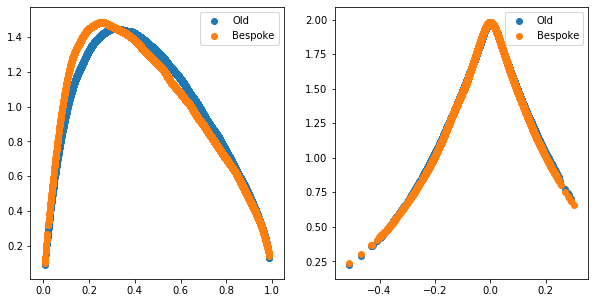

S190412m
1.6653345369377348e-16 4.440892098500626e-16
[0.14717434 0.17604848 0.23195555 ... 0.25573469 0.27043644 0.21991996]


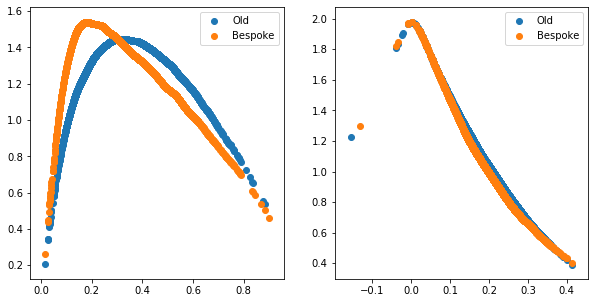

S190413i
3.3306690738754696e-16 0.09701038418811397
[-0.29683068  0.25020912  0.23378541 ... -0.01162552 -0.26540956
 -0.10753007]


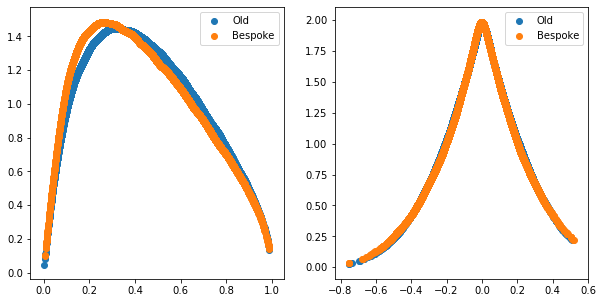

S190413ac
3.3306690738754696e-16 5.828670879282072e-16
[-0.28507042 -0.5326373  -0.12105645 ... -0.23266348 -0.78828399
 -0.1191583 ]


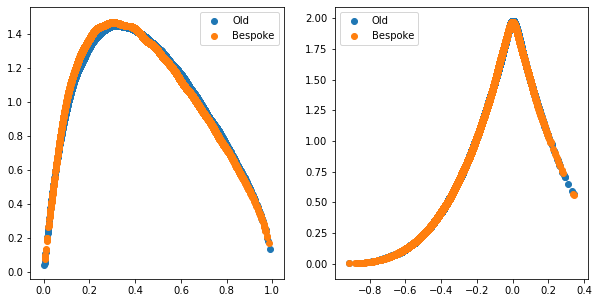

S190421ar
2.7755575615628914e-16 0.09314183317117164
[-0.03425726 -0.17805907 -0.10109728 ... -0.16222869 -0.17153337
 -0.34691144]


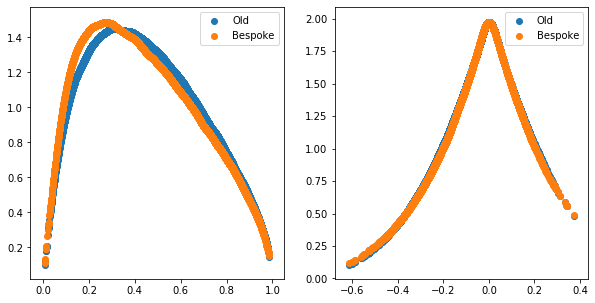

S190424ao
2.7755575615628914e-16 0.09589853115958141
[0.26587657 0.11109231 0.16066762 ... 0.37239477 0.47524361 0.09814776]


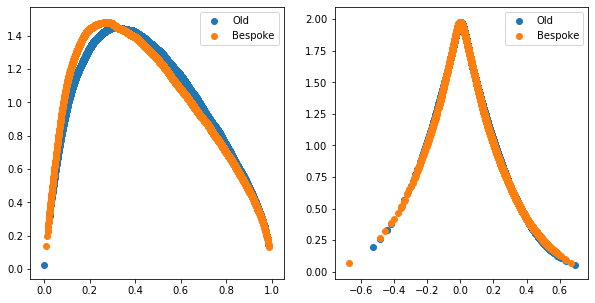

S190503bf
2.220446049250313e-16 0.09633595066166084
[ 0.13017526  0.10743191 -0.28718907 ... -0.02715182  0.1113154
  0.07004478]


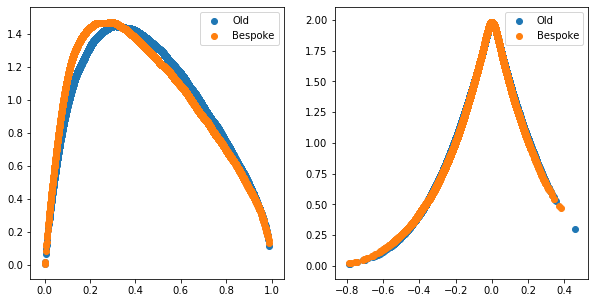

S190512at
1.3877787807814457e-16 5.551115123125783e-16
[-0.00545769  0.0839262   0.1565905  ... -0.10219597 -0.08759205
  0.04824731]


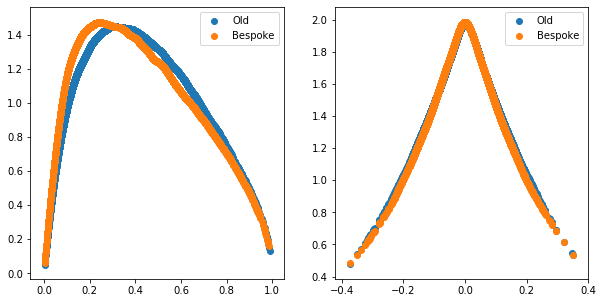

S190513bm
2.7755575615628914e-16 0.0967994150656965
[ 0.06491709  0.36994654 -0.04466772 ...  0.13126183  0.43322794
  0.18638483]


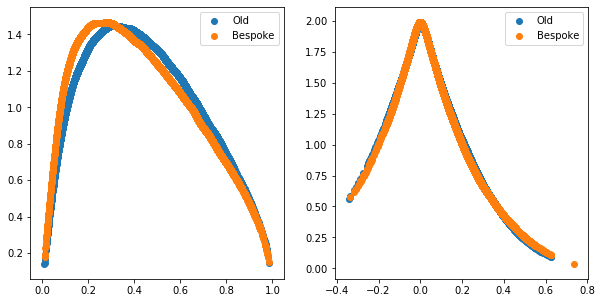

S190514n
3.3306690738754696e-16 0.09656843288181904
[ 0.01017477  0.06741922 -0.43349448 ... -0.0347139  -0.12841152
 -0.37080457]


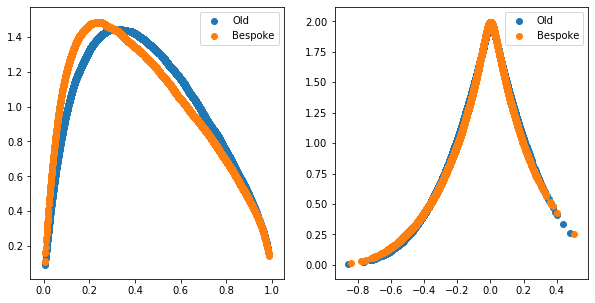

S190517h
3.3306690738754696e-16 0.0943662118284413
[0.51079155 0.60259218 0.72468094 ... 0.57554412 0.56489431 0.76175406]


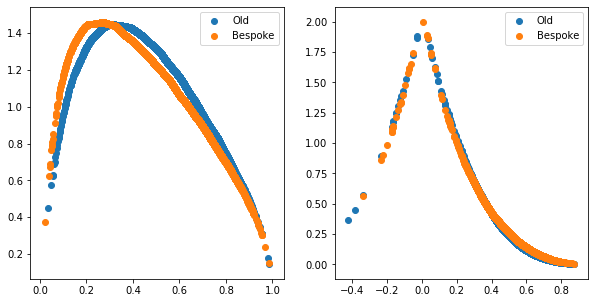

S190519bj
3.3306690738754696e-16 0.09225903636954902
[0.35253587 0.39818803 0.29891215 ... 0.45741144 0.45508794 0.49182649]


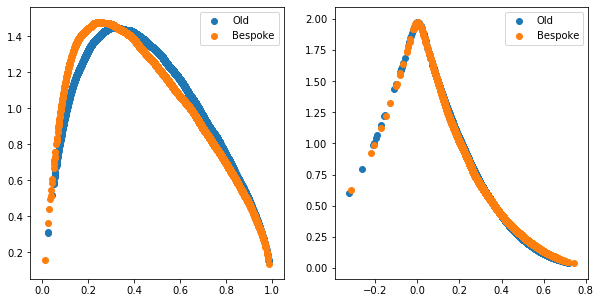

S190521g
2.220446049250313e-16 6.661338147750939e-16
[-0.03836003  0.02343946 -0.29319718 ... -0.00389121  0.1912671
  0.02765843]


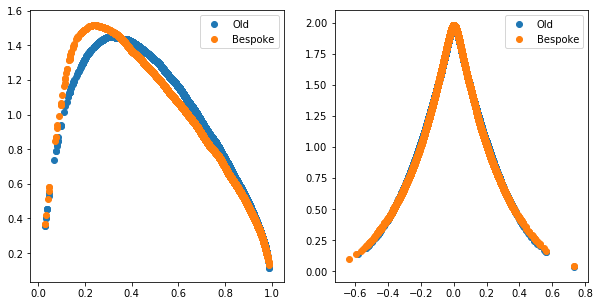

S190521r
1.942890293094024e-16 0.09507400952397943
[-0.0048804  -0.0299759   0.0216395  ...  0.03535079 -0.01233068
 -0.01021175]


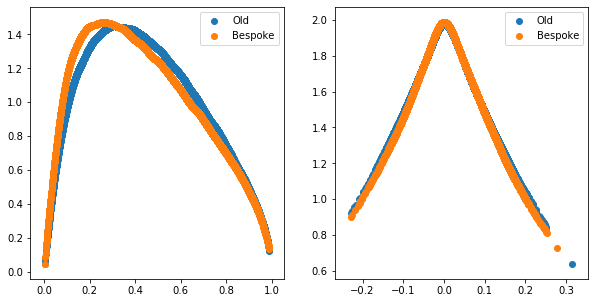

S190527w
3.3306690738754696e-16 0.09707564562578624
[ 0.08618417  0.31625779  0.2079781  ... -0.00235519  0.37226233
  0.63192619]


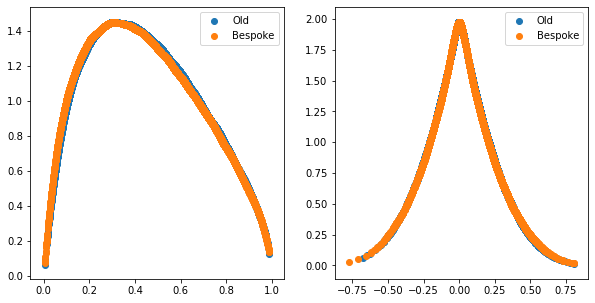

S190602aq
2.220446049250313e-16 0.09559862236180794
[ 0.26715192  0.34151545 -0.05975014 ...  0.15230042 -0.02638069
  0.1017211 ]


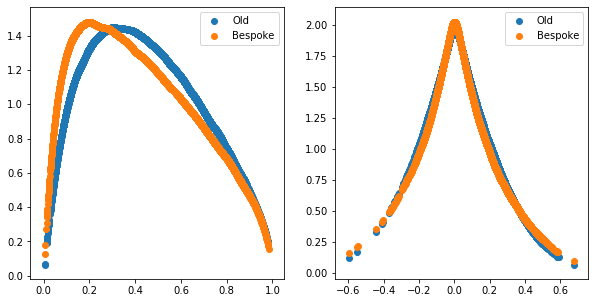

S190620e
3.3306690738754696e-16 0.09678021232546913
[0.10061552 0.28853616 0.54439162 ... 0.39743401 0.35464004 0.125222  ]


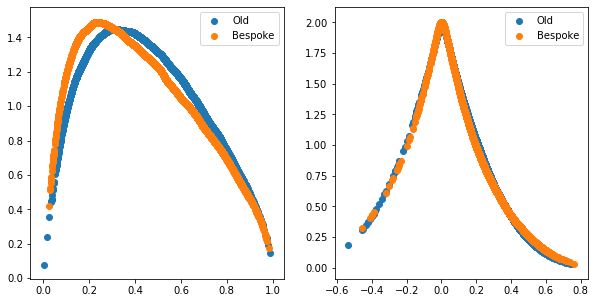

S190630ag
1.942890293094024e-16 0.09675538365001901
[-0.06508476  0.09503716  0.03654674 ... -0.01819078  0.21580604
  0.00671685]


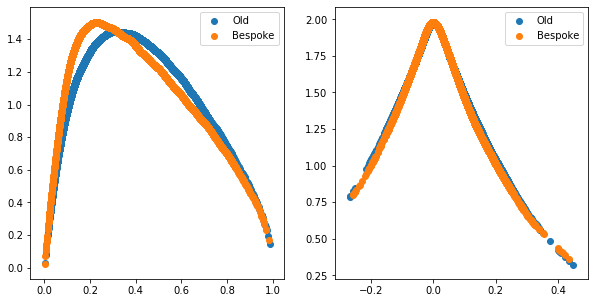

S190701ah
2.220446049250313e-16 6.661338147750939e-16
[-0.04317472 -0.00822155 -0.066642   ... -0.12737978 -0.08314201
 -0.12532706]


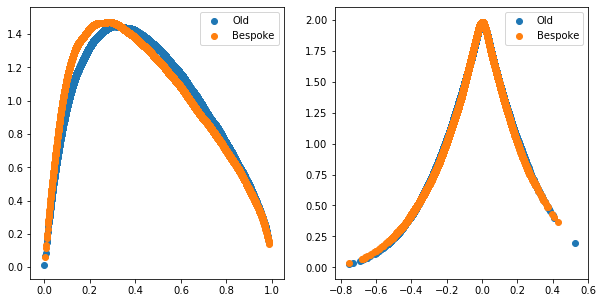

S190706ai
3.3306690738754696e-16 0.09597172321290531
[0.39519345 0.44899627 0.27755117 ... 0.49514477 0.47251888 0.42376176]


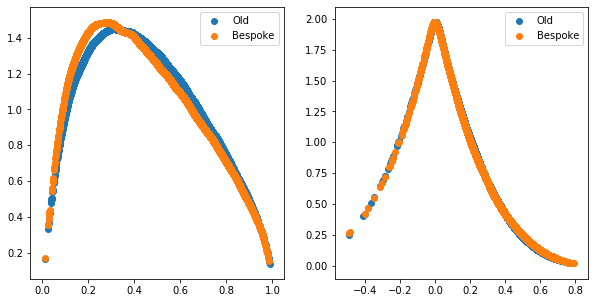

S190707q
1.942890293094024e-16 0.09569391924812087
[-0.08285954  0.00790113 -0.05889352 ... -0.04891656 -0.0363816
 -0.06023722]


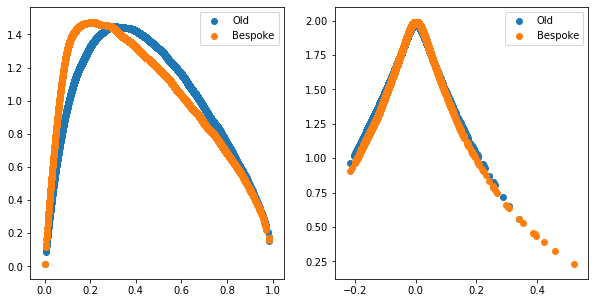

S190708ap
1.6653345369377348e-16 0.09518075169941692
[-0.03633846 -0.07282346 -0.00815459 ... -0.0418623   0.01534491
 -0.00509106]


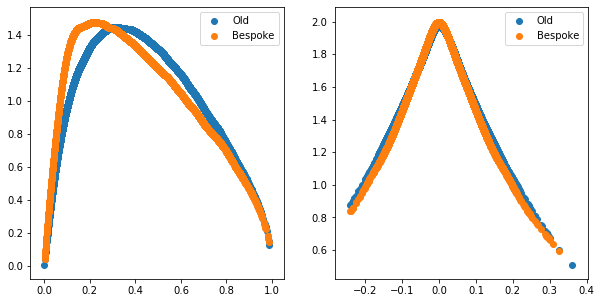

S190719an
4.440892098500626e-16 0.09663703240419147
[0.26665011 0.59057503 0.44165157 ... 0.4887267  0.39549357 0.7967879 ]


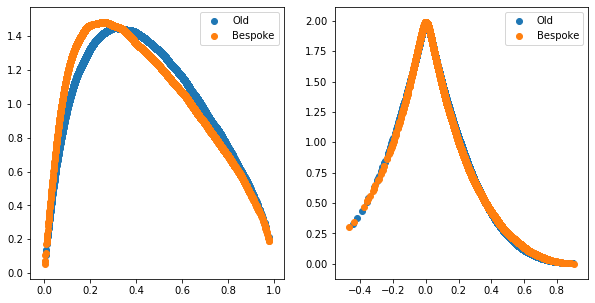

S190720a
1.6653345369377348e-16 5.204170427930421e-16
[0.18902377 0.14609237 0.33417923 ... 0.22081264 0.18858375 0.19187469]


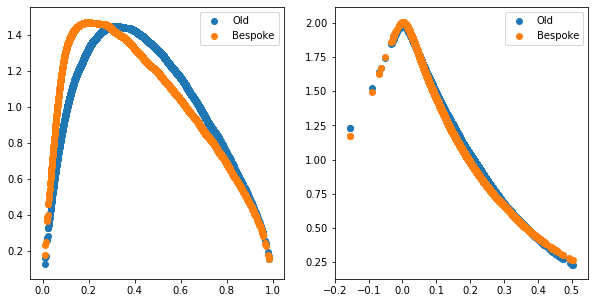

S190727h
1.6653345369377348e-16 0.09421393252907118
[-0.09621273 -0.13879605 -0.02281699 ...  0.11067833 -0.00614963
 -0.04895108]


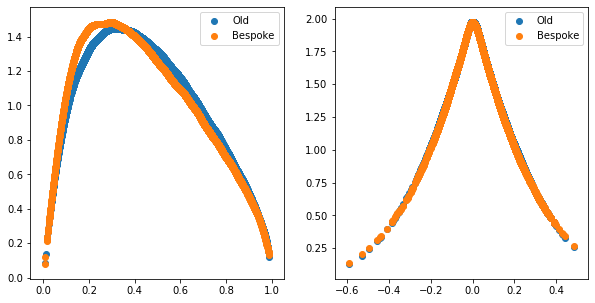

S190728q
2.220446049250313e-16 0.09697367376155708
[0.09704873 0.09341175 0.215668   ... 0.09621521 0.08407167 0.09173915]


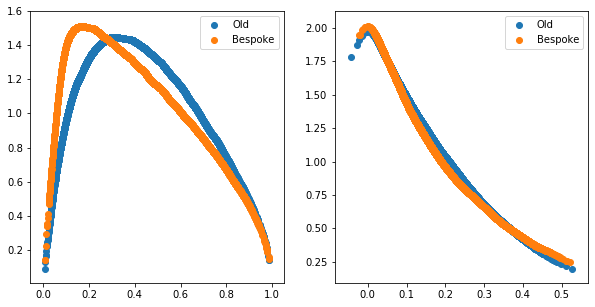

S190731aa
2.220446049250313e-16 1.6237011735142914e-15
[-0.10764011  0.16446139  0.00908827 ...  0.03022515 -0.27032928
  0.00140103]


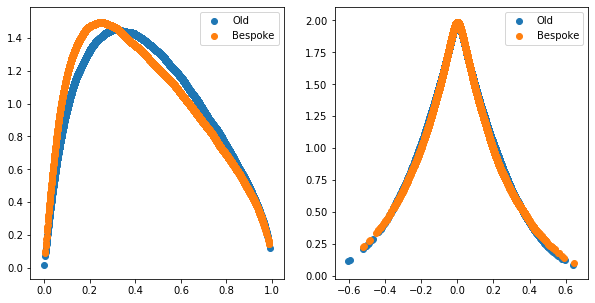

S190803e
2.7755575615628914e-16 0.09412604475935987
[-0.11396408 -0.13450221  0.009984   ... -0.03875586  0.06265916
 -0.00670743]


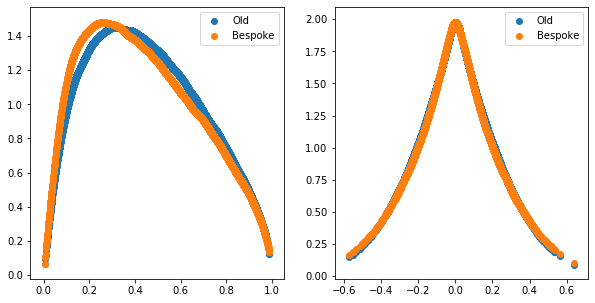

S190828j
2.220446049250313e-16 0.09329547701468432
[ 0.14152625  0.20343838  0.12824401 ...  0.26539728  0.11354946
 -0.00416423]


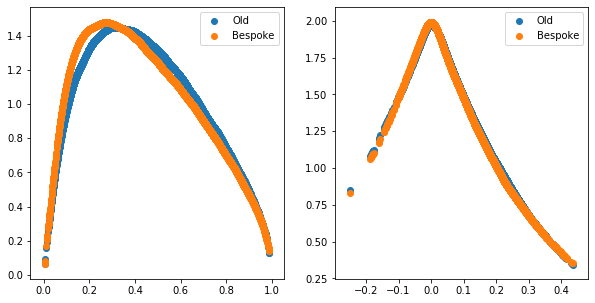

S190828l
1.942890293094024e-16 0.09661662892857487
[ 0.2009227   0.01837689 -0.14459376 ... -0.0732361   0.06356218
  0.14731399]


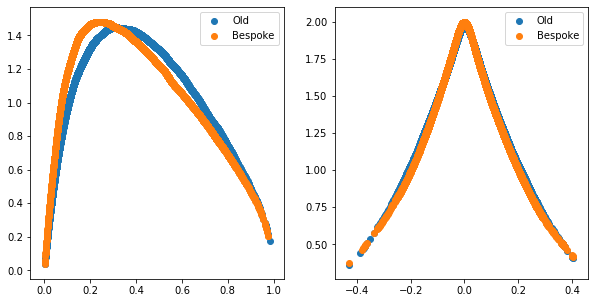

S190909w
3.3306690738754696e-16 1.0061396160665481e-15
[ 0.14883876 -0.3845477   0.0325196  ... -0.06944469 -0.32218161
 -0.03416537]


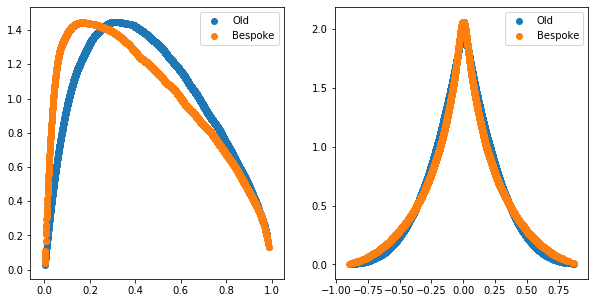

S190910s
2.220446049250313e-16 0.09397844181768367
[ 0.11852247  0.11284784  0.14550805 ... -0.05575902 -0.18557254
  0.0782307 ]


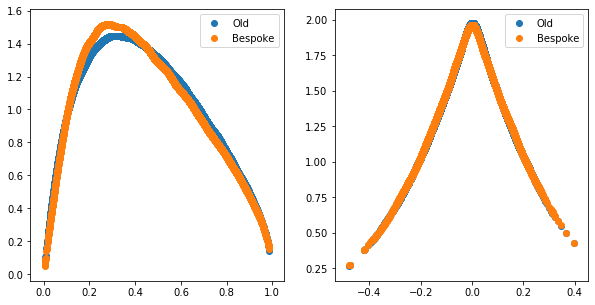

S190915ak
2.220446049250313e-16 0.09634151831875959
[-0.04713235 -0.07806432  0.06999411 ... -0.27105377 -0.08279386
 -0.01808083]


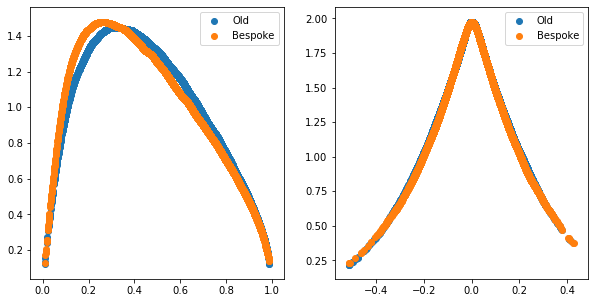

S190924h
2.7755575615628914e-16 0.0969814876812512
[-0.03909809  0.17528092 -0.0885345  ...  0.37213677 -0.03994805
  0.16790209]


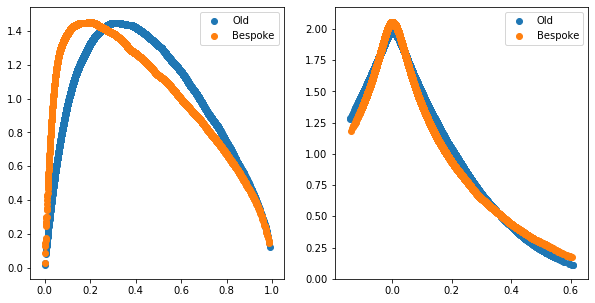

S190929d
2.220446049250313e-16 6.661338147750939e-16
[-0.09427758 -0.19201235  0.00656348 ...  0.16683981  0.27945357
 -0.10392316]


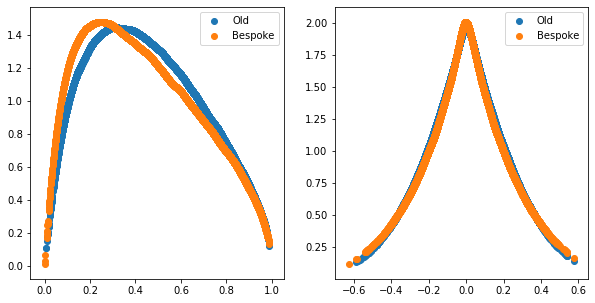

In [13]:
for key in priorBoundsO3:
    
    print(key)
    xeff_prior_samps,xp_prior_samps = drawPriorSamples(1000000,priorBoundsO3[key])
    chiEff_interp_function,chip_interp_function,jointPriorSpline = buildInterpolants(xeff_prior_samps,xp_prior_samps)
    
    sample_files = glob.glob('/home/shanika.galaudage/samples/updated_samples/{0}.*'.format(key))
    if len(sample_files)!=1:
        print("Skipping!",key,sample_files)
        continue
    
    else:
        
        filetype = sample_files[0].split('.')[-1]
        
        if filetype=='json':
            
            with open("/home/shanika.galaudage/samples/updated_samples/{0}.json".format(key)) as posterior_json:
                BBH_post = json.load(posterior_json)

            exp_key = list(BBH_post['posterior_samples'].keys())[0]
            pnames = np.array(BBH_post['posterior_samples'][exp_key]['parameter_names'])

            BBH_post_samples = np.array(BBH_post['posterior_samples'][exp_key]['samples'])
            m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_1_source')])
            m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_2_source')])
            a1 = np.squeeze(BBH_post_samples[:,(pnames=='a_1')])
            a2 = np.squeeze(BBH_post_samples[:,(pnames=='a_2')])
            cost1 = np.squeeze(BBH_post_samples[:,(pnames=='cos_tilt_1')])
            cost2 = np.squeeze(BBH_post_samples[:,(pnames=='cos_tilt_2')])
            Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
            Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
            Xeff_direct = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
            Xp_direct = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
            DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])
            z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
            
            print(np.max(np.abs(Xeff-Xeff_direct)),np.max(np.abs(Xp-Xp_direct)))
            
        elif filetype=='dat':
            
            datfile = "/home/shanika.galaudage/samples/updated_samples/{0}.dat".format(key)
            pnames = np.loadtxt(datfile,max_rows=1,dtype=str)

            BBH_post_samples = np.loadtxt(datfile,skiprows=1)
            m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='m1_source')])
            m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='m2_source')])
            a1 = np.squeeze(BBH_post_samples[:,(pnames=='a1')])
            a2 = np.squeeze(BBH_post_samples[:,(pnames=='a2')])
            cost1 = np.squeeze(BBH_post_samples[:,(pnames=='costilt1')])
            cost2 = np.squeeze(BBH_post_samples[:,(pnames=='costilt2')])
            Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
            Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
            Xeff_direct = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
            Xp_direct = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
            
            print(np.max(np.abs(Xeff-Xeff_direct)),np.max(np.abs(Xp-Xp_direct)))

            #if name=="S190521g":
            if 'dist' in pnames:
                DL = np.squeeze(BBH_post_samples[:,(pnames=='dist')])
            else:
                DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])

            z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
            
        elif filetype=='h5':
            
            f = h5py.File('/home/shanika.galaudage/samples/updated_samples/{0}.h5'.format(key),'r')
            exps = list(f['posterior_samples'].keys())
            if len(exps)>1:
                print("More than one waveform!!!!")

            exp = exps[0]
            pnames = np.array(f['posterior_samples'][exp]['parameter_names']).astype(str)
            
            BBH_post_samples = np.array(f['posterior_samples'][exp]['samples'])
            m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_1_source')])
            m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_2_source')])
            a1 = np.squeeze(BBH_post_samples[:,(pnames=='a_1')])
            a2 = np.squeeze(BBH_post_samples[:,(pnames=='a_2')])
            cost1 = np.squeeze(BBH_post_samples[:,(pnames=='cos_tilt_1')])
            cost2 = np.squeeze(BBH_post_samples[:,(pnames=='cos_tilt_2')])
            Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
            Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
            Xeff_direct = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
            Xp_direct = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
            DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])
            z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
            f.close()

            print(np.max(np.abs(Xeff-Xeff_direct)),np.max(np.abs(Xp-Xp_direct)))            
            
        else:
            print("error!!!")
            
    # Downselect to a reasonable number of samples
    nSamps = min(10000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    
    print(Xeff)

    # Get xeff priors
    Xeff_priors = chiEff_interp_function(Xeff)
    Xp_priors = chip_interp_function(Xp)
    joint_priors = evaluateJointPrior(Xeff,Xp,jointPriorSpline)

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_SF*(1+z))
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    #sampleDict[key] = {\
    #                    'Xeff':Xeff,\
    #                    'Xp':Xp,\
    #                    'Xeff_priors':Xeff_priors,\
    #                    'Xp_priors':Xp_priors,\
    #                    'joint_priors':joint_priors,\
    #                    'weights':weights,\
    #                    'm1':m1_SF,\
    #                    'm2':m2_SF\
    #                   }
    
    preprocDict = {'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF\
                       }
    np.save('preprocessed-single-events/{0}.npy'.format(key),preprocDict)
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax.scatter(referenceSamples[key]['Xp'],referenceSamples[key]['Xp_priors'],label='Old')
    ax.scatter(Xp,Xp_priors,label='Bespoke')
    plt.legend(loc='best')
    ax = fig.add_subplot(122)
    ax.scatter(referenceSamples[key]['Xeff'],referenceSamples[key]['Xeff_priors'],label='Old')
    ax.scatter(Xeff,Xeff_priors,label='Bespoke')
    plt.legend(loc='best')
    plt.show()

In [14]:
sampleDict = {}
singleEvents = glob.glob('./preprocessed-single-events/*')
for eventFile in singleEvents:
    
    key = re.split('\/|\.',eventFile)[-2]
    dataDict = np.load(eventFile,allow_pickle=True)[()]
    sampleDict[key] = dataDict

import pickle
with open('sampleDict_shanika_2020-04-13_bespokePrior.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

---
# Scratch work

In [15]:
samples1 = np.load('sampleDict_shanika_2020-04-13_directChiP.pickle',allow_pickle=True)
samples2 = np.load('sampleDict_shanika_2020-04-13_bespokePrior.pickle',allow_pickle=True)

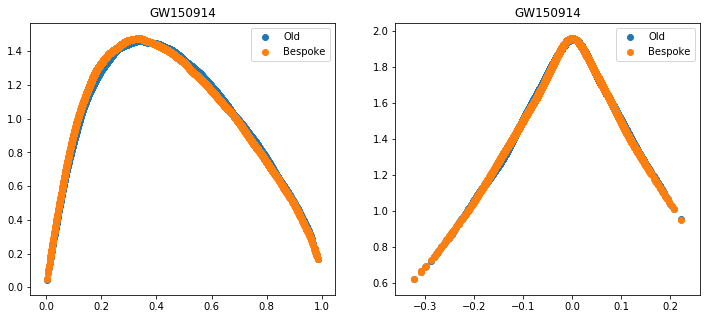

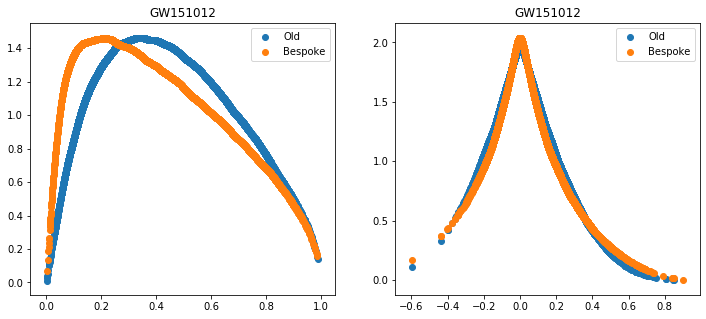

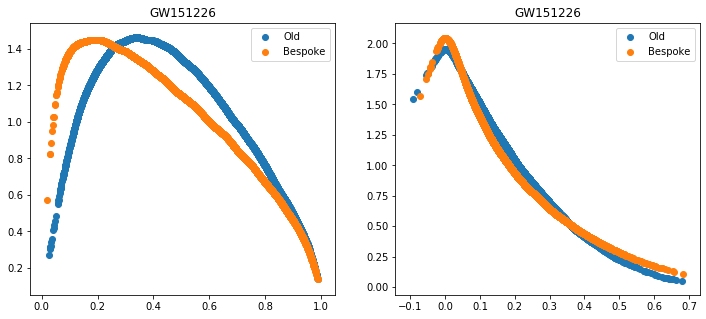

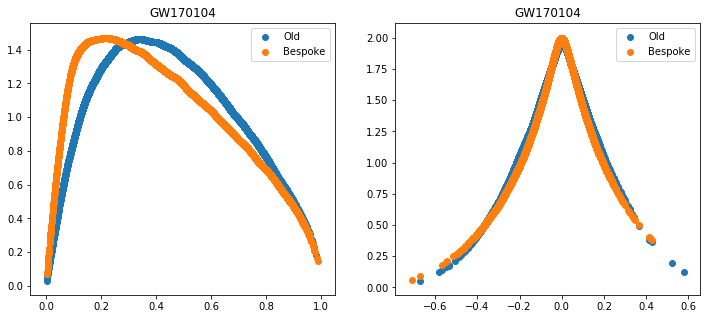

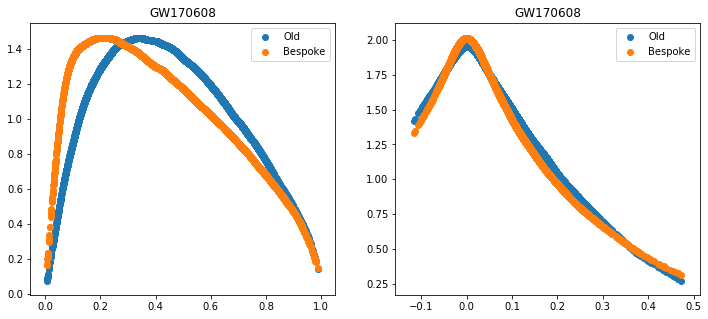

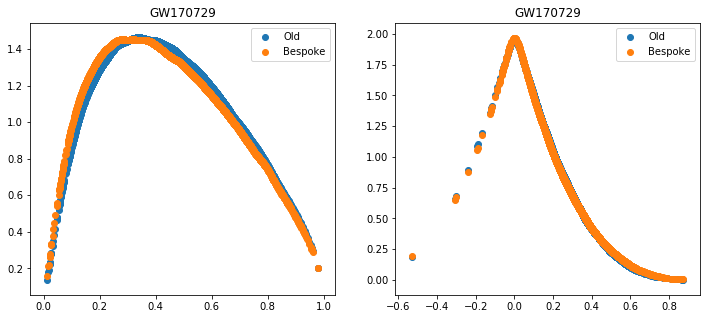

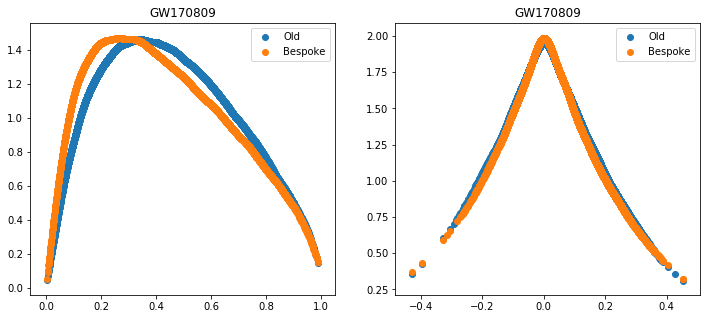

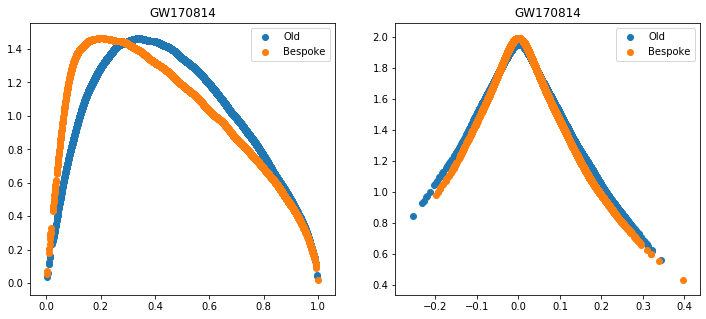

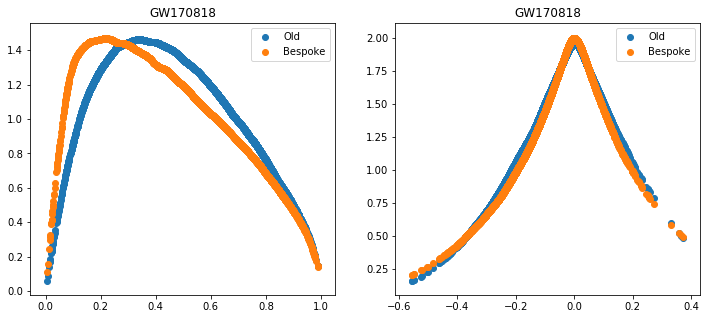

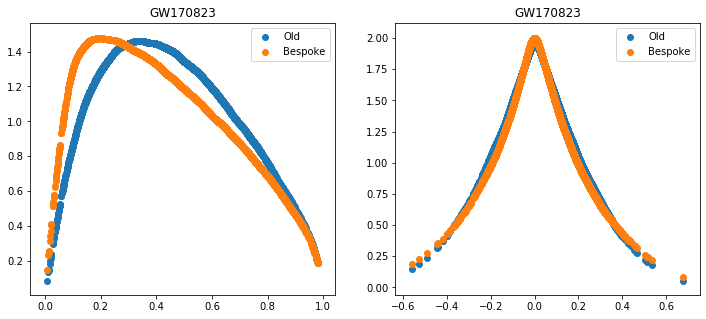

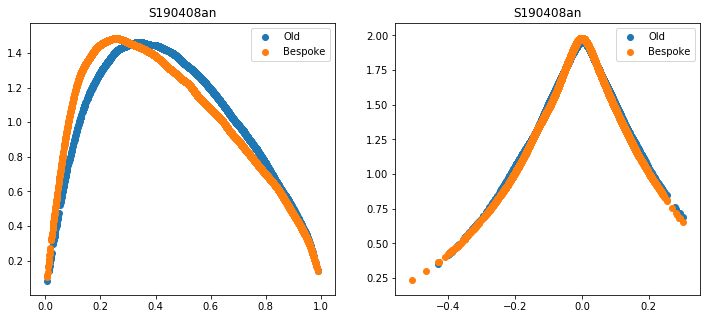

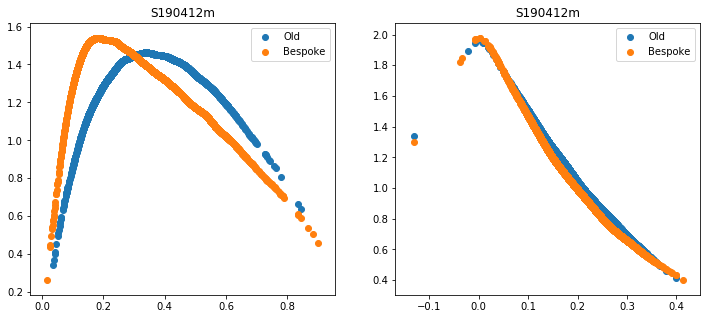

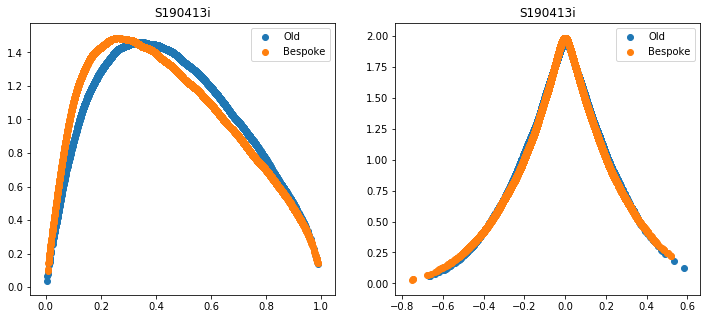

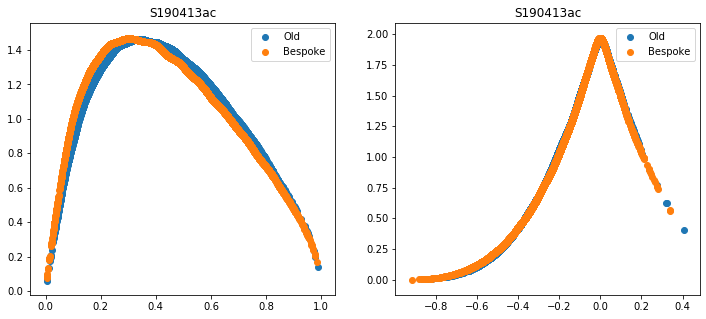

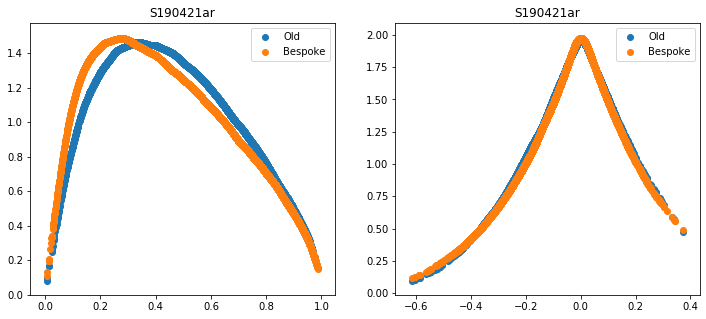

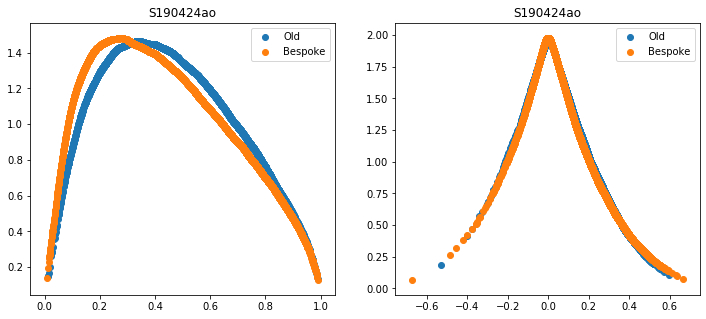

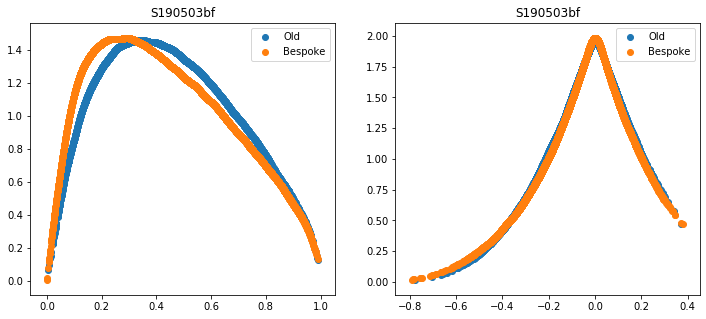

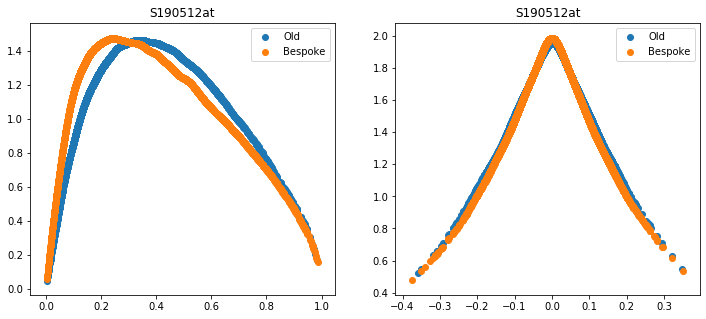

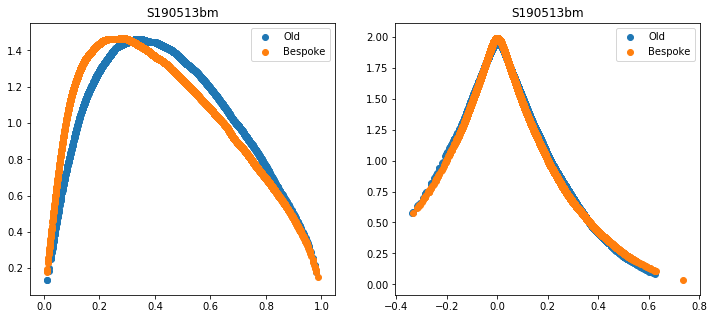

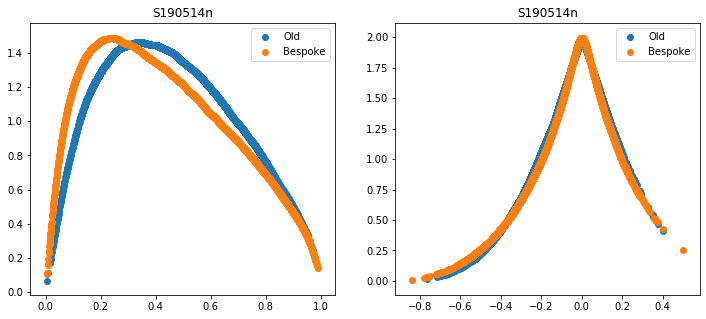

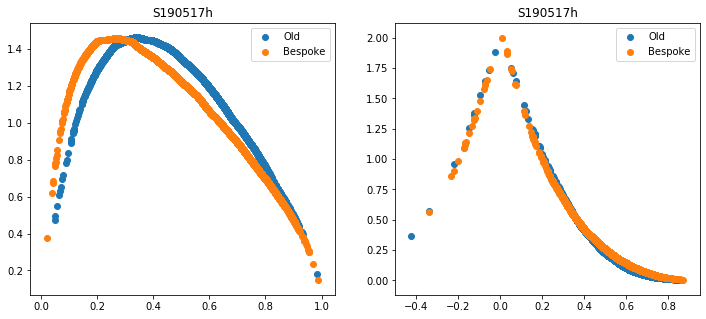

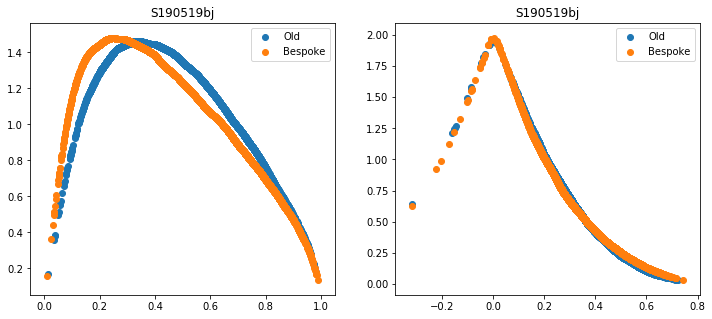

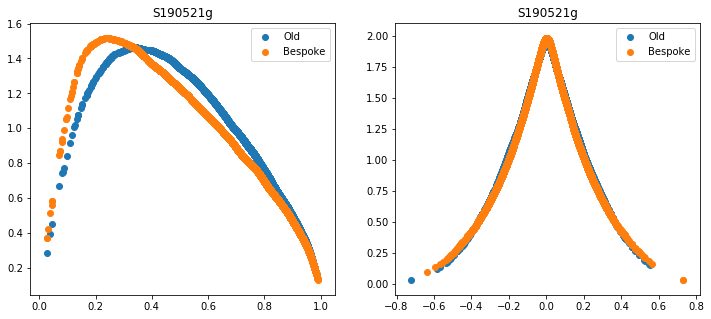

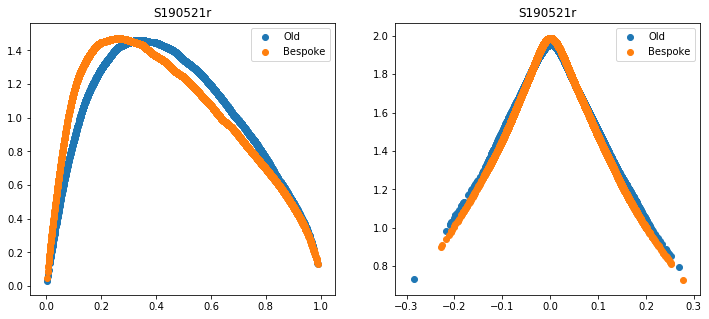

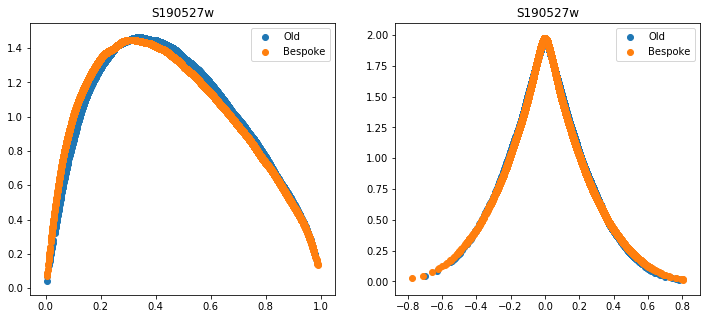

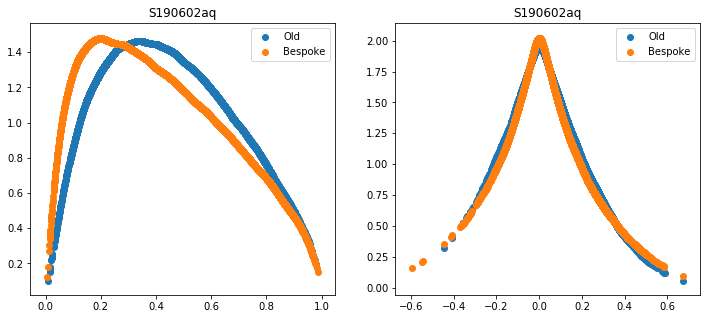

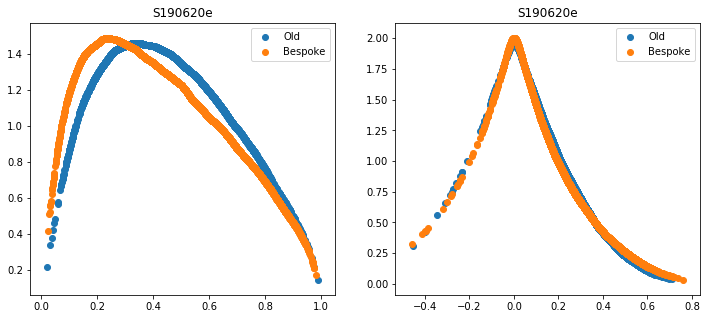

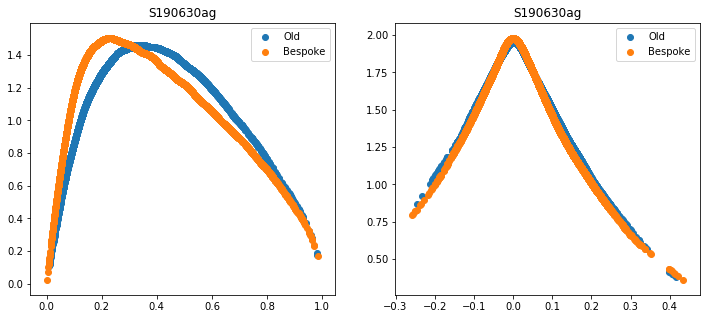

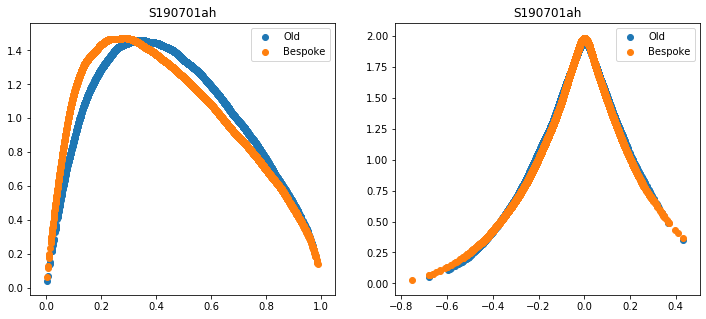

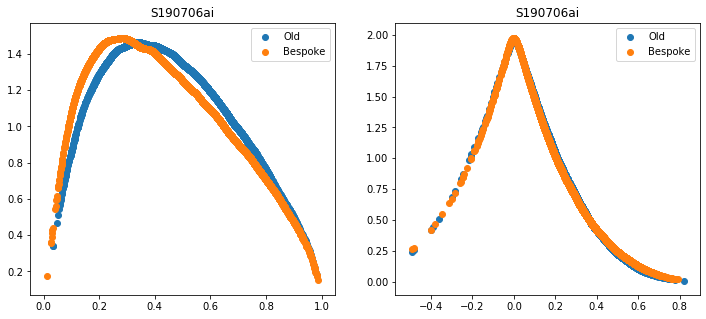

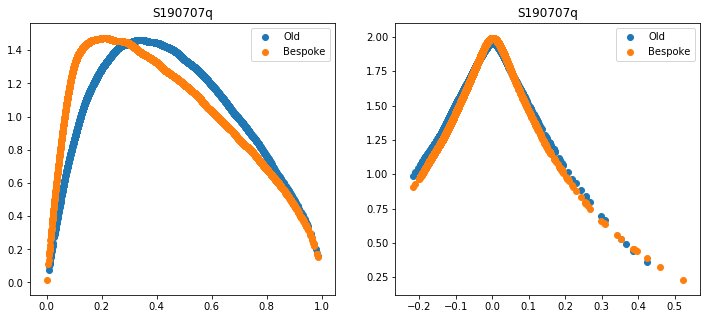

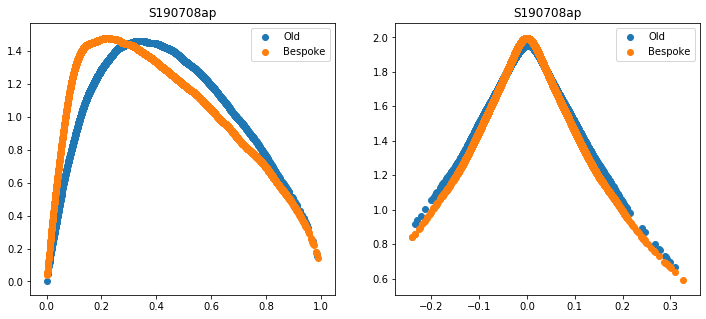

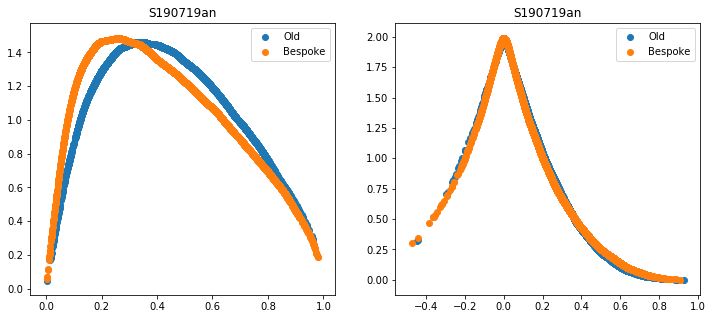

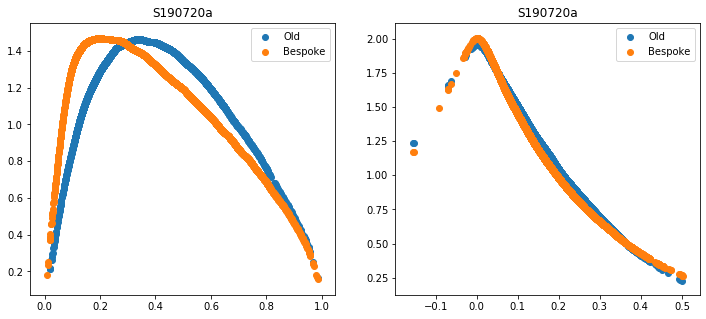

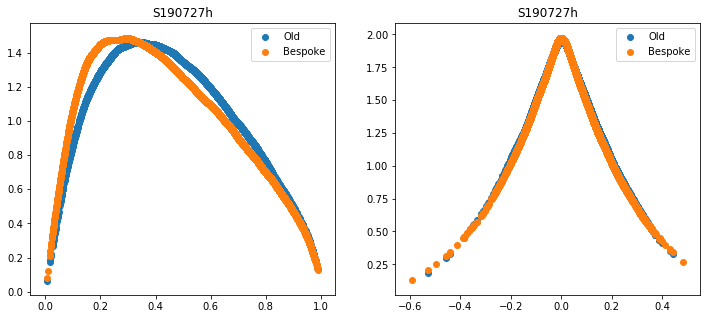

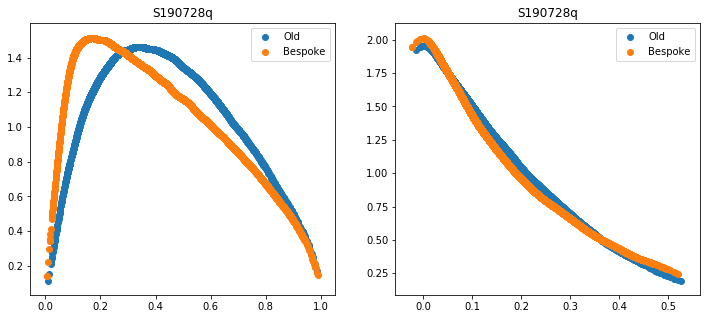

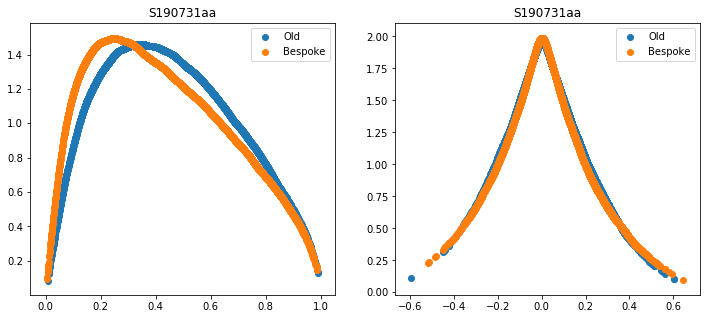

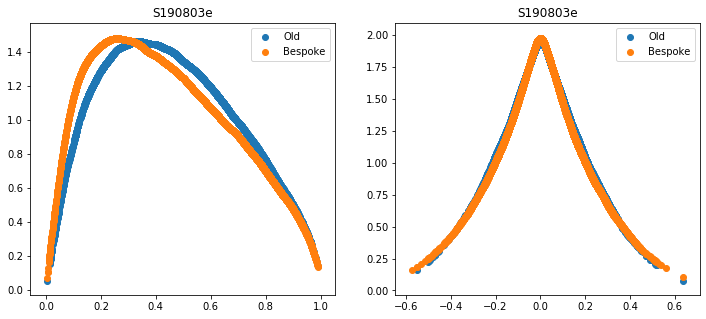

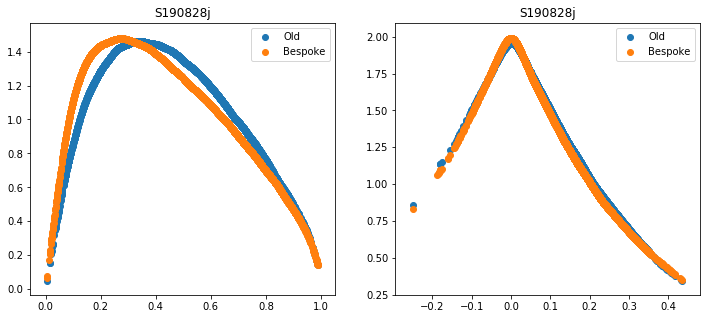

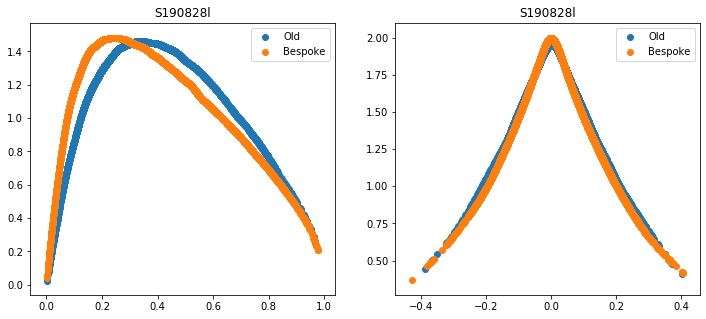

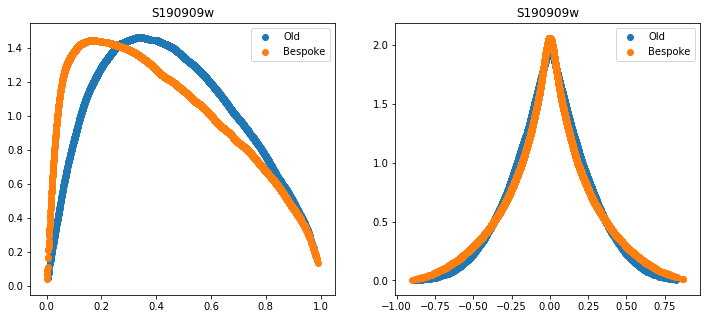

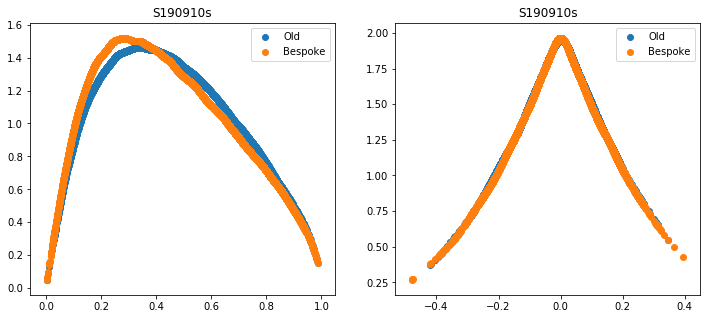

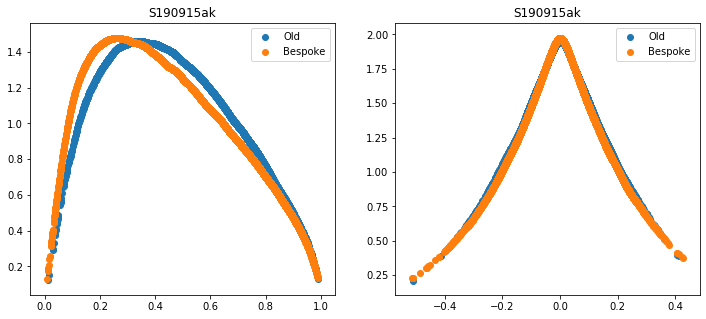

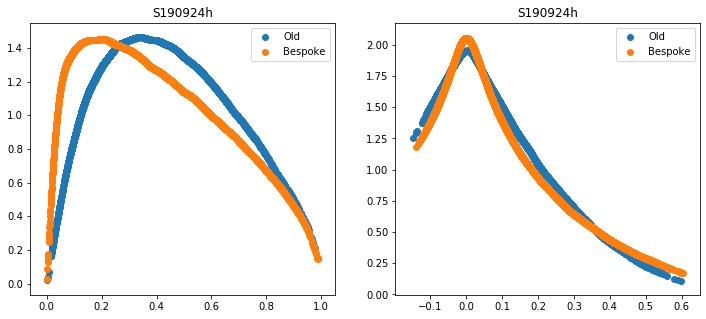

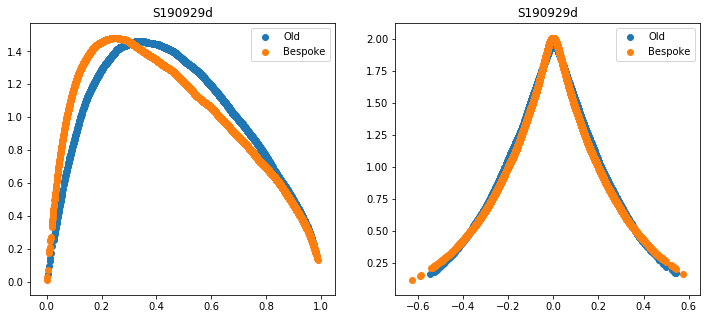

In [16]:
for key in samples1.keys():
    
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.scatter(samples1[key]['Xp'],samples1[key]['Xp_priors'],label='Old')
    ax.scatter(samples2[key]['Xp'],samples2[key]['Xp_priors'],label='Bespoke')
    plt.legend(loc='best')
    ax.set_title(key)
    ax = fig.add_subplot(122)
    ax.scatter(samples1[key]['Xeff'],samples1[key]['Xeff_priors'],label='Old')
    ax.scatter(samples2[key]['Xeff'],samples2[key]['Xeff_priors'],label='Bespoke')
    plt.legend(loc='best')
    ax.set_title(key)
    plt.show()

---

In [84]:
BBH_names = ['GW151012', 'GW170608', 'GW170729', 'GW151226', 'GW170814', 'GW150914', 'GW170104', 'GW170809', 'GW170818', 'GW170823']
for name in BBH_names:

    print(name)

    # load samples
    BBH_post = h5py.File('./GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(name), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']

    # Downselect to a reasonable number of samples
    nSamps = min(10000,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
        
    # Get xeff priors
    Xeff_priors = chiEff_interp_function(Xeff)
    Xp_priors = chip_interp_function(Xp)
    joint_priors = evaluateJointPrior(Xeff,Xp)
    
    #Xp_logit_priors = xlog_prior_kde(Xlog)/Xp/(1.-Xp)
    #Xp_spl_priors = spl(Xp)/spl_norm
    #joint_logit_priors = joint_logit_prior_kde([Xeff,Xlog])/Xp/(1.-Xp)

    # Redshift and mass priors
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_DF)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    sampleDict[name] = {\
                        'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_DF/(1.+z),\
                        'm2':m2_DF/(1.+z)\
                       }

GW151012
GW170608
GW170729
GW151226
GW170814
GW150914
GW170104
GW170809
GW170818
GW170823


Next, do the same thing for the O3a events. Note that the O3a .h5 files have slightly different keys. Additionally, the current S190521g samples themselves use a different key system. We naively catch this with a "try/except" conditional...

In [90]:
BBH_names= [
'S190408an',
'S190412m',
'S190413ac',
'S190413i',
'S190421ar',
'S190424ao',
'S190503bf',
'S190512at',
'S190513bm',
'S190514n',
'S190517h',
'S190519bj',
'S190521g',
'S190521r',
'S190527w',
'S190602aq',
'S190620e',
'S190630ag',
'S190701ah',
'S190706ai',
'S190707q',
'S190708ap',
'S190719an',
'S190720a',
'S190727h',
'S190728q',
'S190731aa',
'S190803e',
'S190828j',
'S190828l',
'S190909w',
'S190910s',
'S190915ak',
'S190924h',
'S190929d']
#'S190930s'] ### No chip???

for name in BBH_names:
    
    print(name)
    
    sample_files = glob.glob('/home/shanika.galaudage/samples/updated_samples/{0}.*'.format(name))
    if len(sample_files)!=1:
        print("Skipping!",name,sample_files)
        continue
    
    else:
        
        filetype = sample_files[0].split('.')[-1]
        
        if filetype=='json':
            
            with open("/home/shanika.galaudage/samples/updated_samples/{0}.json".format(name)) as posterior_json:
                BBH_post = json.load(posterior_json)

            exp_key = list(BBH_post['posterior_samples'].keys())[0]
            pnames = np.array(BBH_post['posterior_samples'][exp_key]['parameter_names'])

            BBH_post_samples = np.array(BBH_post['posterior_samples'][exp_key]['samples'])
            m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_1_source')])
            m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_2_source')])
            Xeff = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
            Xp = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
            DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])
            z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
            
        elif filetype=='dat':
            
            datfile = "/home/shanika.galaudage/samples/updated_samples/{0}.dat".format(name)
            pnames = np.loadtxt(datfile,max_rows=1,dtype=str)

            BBH_post_samples = np.loadtxt(datfile,skiprows=1)
            m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='m1_source')])
            m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='m2_source')])
            Xeff = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
            Xp = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])

            #if name=="S190521g":
            if 'dist' in pnames:
                DL = np.squeeze(BBH_post_samples[:,(pnames=='dist')])
            else:
                DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])

            z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
            
        elif filetype=='h5':
            
            f = h5py.File('/home/shanika.galaudage/samples/updated_samples/{0}.h5'.format(name),'r')
            exps = list(f['posterior_samples'].keys())
            if len(exps)>1:
                print("More than one waveform!!!!")

            exp = exps[0]
            pnames = np.array(f['posterior_samples'][exp]['parameter_names']).astype(str)
            
            BBH_post_samples = np.array(f['posterior_samples'][exp]['samples'])
            m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_1_source')])
            m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_2_source')])
            Xeff = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
            Xp = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
            DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])
            z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
            
        else:
            print("error!!!")
            
    # Downselect to a reasonable number of samples
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]

    # Get xeff priors
    Xeff_priors = chiEff_interp_function(Xeff)
    Xp_priors = chip_interp_function(Xp)
    joint_priors = evaluateJointPrior(Xeff,Xp)

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL,m1_SF*(1+z))
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    sampleDict[name] = {\
                        'Xeff':Xeff,\
                        'Xp':Xp,\
                        'Xeff_priors':Xeff_priors,\
                        'Xp_priors':Xp_priors,\
                        'joint_priors':joint_priors,\
                        'weights':weights,\
                        'm1':m1_SF,\
                        'm2':m2_SF\
                       }

"""
    try:
        print(name)

        with open("/home/shanika.galaudage/samples/updated_samples/{0}.json".format(name)) as posterior_json:
            BBH_post = json.load(posterior_json)

        exp_key = list(BBH_post['posterior_samples'].keys())[0]
        pnames = np.array(BBH_post['posterior_samples'][exp_key]['parameter_names'])

        BBH_post_samples = np.array(BBH_post['posterior_samples'][exp_key]['samples'])
        m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_1_source')])
        m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='mass_2_source')])
        Xeff = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
        Xp = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
        DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])
        z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])
                
    except:
        
        datfile = "/home/shanika.galaudage/samples/updated_samples/{0}.dat".format(name)
        pnames = np.loadtxt(datfile,max_rows=1,dtype=str)
        
        BBH_post_samples = np.loadtxt(datfile,skiprows=1)
        m1_SF = np.squeeze(BBH_post_samples[:,(pnames=='m1_source')])
        m2_SF = np.squeeze(BBH_post_samples[:,(pnames=='m2_source')])
        Xeff = np.squeeze(BBH_post_samples[:,(pnames=='chi_eff')])
        Xp = np.squeeze(BBH_post_samples[:,(pnames=='chi_p')])
        
        #if name=="S190521g":
        if 'dist' in pnames:
            DL = np.squeeze(BBH_post_samples[:,(pnames=='dist')])
        else:
            DL = np.squeeze(BBH_post_samples[:,(pnames=='luminosity_distance')])
        
        z = np.squeeze(BBH_post_samples[:,(pnames=='redshift')])

"""

S190408an
11637
[    0     1     2 ... 11633 11634 11636]
0
10000
S190412m
14264
[    2     3     4 ... 14260 14261 14263]
0
10000
S190413ac
50117
[    0     6    10 ... 50111 50114 50115]
11
10000
S190413i
66169
[    4     9    37 ... 66152 66153 66158]
0
10000
S190421ar
9087
[   0    1    2 ... 9084 9085 9086]
0
9087
S190424ao
30664
[    0     4     5 ... 30659 30661 30663]
0
10000
S190503bf
16185
[    0     1     2 ... 16176 16183 16184]
0
10000
S190512at
12045
[    0     1     2 ... 12042 12043 12044]
0
10000
S190513bm
24801
[    4     9    20 ... 24794 24797 24799]
0
10000
S190514n
36200
[    5     8    12 ... 36175 36184 36196]
1
10000
S190517h
25356
[    0     1     2 ... 25348 25351 25354]
0
10000
S190519bj
44448
[    9    23    34 ... 44433 44437 44447]
0
10000
S190521g
31572
[    0     4    13 ... 31559 31565 31566]
0
10000
S190521r
19589
[    1     2     3 ... 19586 19587 19588]
0
10000
S190527w
53120
[    1     6    17 ... 53105 53117 53119]
0
10000
S190602aq
11120
[    0  

'\n    try:\n        print(name)\n\n        with open("/home/shanika.galaudage/samples/updated_samples/{0}.json".format(name)) as posterior_json:\n            BBH_post = json.load(posterior_json)\n\n        exp_key = list(BBH_post[\'posterior_samples\'].keys())[0]\n        pnames = np.array(BBH_post[\'posterior_samples\'][exp_key][\'parameter_names\'])\n\n        BBH_post_samples = np.array(BBH_post[\'posterior_samples\'][exp_key][\'samples\'])\n        m1_SF = np.squeeze(BBH_post_samples[:,(pnames==\'mass_1_source\')])\n        m2_SF = np.squeeze(BBH_post_samples[:,(pnames==\'mass_2_source\')])\n        Xeff = np.squeeze(BBH_post_samples[:,(pnames==\'chi_eff\')])\n        Xp = np.squeeze(BBH_post_samples[:,(pnames==\'chi_p\')])\n        DL = np.squeeze(BBH_post_samples[:,(pnames==\'luminosity_distance\')])\n        z = np.squeeze(BBH_post_samples[:,(pnames==\'redshift\')])\n                \n    except:\n        \n        datfile = "/home/shanika.galaudage/samples/updated_samples/{0}.

In [95]:
import pickle
with open('sampleDict_shanika_2020-03-30.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)

Save some draws from the chi-p prior:

(array([185., 186.,  81.,  30.,   7.,   4.,   3.,   2.,   1.,   1.]),
 array([-0.47012491, -0.20051158,  0.06910176,  0.33871509,  0.60832843,
         0.87794176,  1.1475551 ,  1.41716843,  1.68678177,  1.9563951 ,
         2.22600844]),
 <a list of 10 Patch objects>)

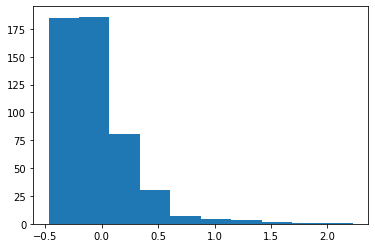

In [330]:
plt.hist(np.log10(ws))

In [267]:
import pickle
with open('sampleDictPrior.pickle','wb') as testfile:
    pickle.dump(sampleDictPrior,testfile,protocol=2)

In [ ]:
# S190408an: PROD0, IMRPhenomPv2pseudoFourPN
# S190412m: Preferred, IMRPhenomPv2pseudoFourPN
# S190413i: Preferred, C01 IMRPhenomPv2pseudoFourPN
# S190413ac: Preferred, C01 IMRPhenomPv2pseudoFourPN
# S190421ar: Preferred, C01:IMRPhenomPv2
# S190424ao: Preferred, C01:IMRPhenomPv2
# S190503bf: Preferred, PROD2
# S190512at: Preferred, C01:IMRPhenomPv2
# S190513bm: Preferred, C01:IMRPhenomPv2
# S190514n: Preferred, C01:IMRPhenomPv2
# S190517h: Preferred, C01:IMRPhenomPv2
# S190519bj: Preferred, C01:IMRPhenomPv2
# S190521g: Preferred, C01:NRSur7dq4
# S190521r: Preferred, C01:IMRPhenomPv2
# S190527w: Preferred, C01:IMRPhenomPv2
# S190602aq: Preferred, C01:IMRPhenomPv2
# S190620e: Preferred, C01:IMRPhenomPv2
# S190630ag: Preferred, C01:IMRPhenomPv2
# S190701ah: Preferred, C01:IMRPhenomPv2
# S190706ai: Preferred, C01:IMRPhenomPv2
# S190707q: Preferred, PROD0
# S190708ap: Preferred, C01:IMRPhenomPv2
# S190719an: Preferred, PROD0
# S190720a: Preferred, PROD2
# S190727h: Preferred, C01:IMRPhenomPv2
# S190728q: Preferred, C01:IMRPhenomPv2
# S190731aa: Preferred, C01:IMRPhenomPv2
# S190803e: Preferred, C01:IMRPhenomPv2
# S190828j: Preferred, C01:IMRPhenomPv2
# S190828l: Preferred, C01:IMRPhenomPv2
# S190909w: Preferred, PROD6
# S190910s: Preferred, C01:IMRPhenomPv2
# S190915ak: Preferred, C01:IMRPhenomPv2
# S190924h: C01:IMRPhenomPv2
# S190929d: C01:IMRPhenomPv2

priorBoundsO3 = {
    'S190408an':{'m_min':7.,'m_max':80.,'q_min':0.125,'q_max':1,'mc_min':15.,'mc_max':30.,'mtotal_min':45,'mtotal_max':70},
    'S190412m':{'m_min':5.,'m_max':60.,'q_min':0.125,'q_max':1,'mc_min':13.,'mc_max':18.,'mtotal_min':35,'mtotal_max':55},    
    'S190413i':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.125,'q_max':1,'mc_min':24.,'mc_max':60.,'mtotal_min':60.,'mtotal_max':125.},    
    'S190413ac':{'m_min':5.,'m_max':200.,'q_min':0.125,'q_max':1,'mc_min':20.,'mc_max':150.},    
    'S190421ar':{'m_min':10.,'m_max':120.,'q_min':0.125,'q_max':1,'mc_min':25.,'mc_max':70.,'mtotal_min':80.,'mtotal_max':155.},    
    'S190424ao':{'m_min':10.,'m_max':140.,'q_min':0.125,'q_max':1,'mc_min':22.,'mc_max':80.,'mtotal_min':55.,'mtotal_max':180.},    
    'S190503bf':{'q_min':0.125,'q_max':1,'mtotal_min':60.,'mtotal_max':125.},    
    'S190512at':{'q_min':0.125,'q_max':1,'mtotal_min':40.,'mtotal_max':65.},    
    'S190513bm':{'q_min':0.125,'q_max':1,'mtotal_min':60.,'mtotal_max':110.},    
    'S190514n':{'m_min':5.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':20.,'mc_max':100.},    
    'S190517h':{'m_min':5.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':20.,'mc_max':60.,'mtotal_min':55.,'mtotal_max':135.},    
    'S190519bj':{'m_min':20.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':40.,'mc_max':90.,'mtotal_min':120.,'mtotal_max':215.},    
    'S190521g':{'m_min':30.,'m_max':300.,'q_min':0.17,'q_max':1,'mc_min':70.,'mc_max':150.,'mtotal_min':200.},    
    'S190521r':{'q_min':0.125,'q_max':1,'mtotal_min':80.,'mtotal_max':110.},    
    'S190527w':{'q_min':0.05,'q_max':1,'mtotal_min':55.,'mtotal_max':200.,'mc_min':12.,'mc_max':90.},    
    'S190602aq':{'m_min':10.,'m_max':300.,'q_min':0.05,'q_max':1,'mc_min':25.,'mc_max':120.},    
    'S190620e':{'m_min':10.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':25.,'mc_max':100.},    
    'S190630ag':{'m_min':10.,'m_max':100.,'q_min':0.125,'q_max':1,'mc_min':15.,'mc_max':45.},
    'S190701ah':{'m_min':10.,'m_max':140.,'q_min':0.125,'q_max':1,'mc_min':22.,'mc_max':80.,'mtotal_min':95,'mtotal_max':170},
    'S190706ai':{'m_min':15.,'m_max':200.,'q_min':0.125,'q_max':1,'mc_min':30.,'mc_max':120.,'mtotal_min':100,'mtotal_max':275},
    'S190707q':{'m_min':4.,'m_max':40.,'q_min':0.125,'q_max':1,'mc_min':9.,'mc_max':11.,'mtotal_min':20,'mtotal_max':40},
    'S190708ap':{'m_min':5.,'m_max':50.,'q_min':0.125,'q_max':1,'mc_min':13.,'mc_max':17.,'mtotal_min':27.,'mtotal_max':60.},
    'S190719an':{'m_min':10.962740400025913,'m_max':320.8684424338806,'q_min':0.125,'q_max':1,'mc_min':24.599406,'mc_max':100.,'mtotal_min':60.,'mtotal_max':250.},
    'S190720a':{'m_min':3.,'m_max':50.,'q_min':0.125,'q_max':1,'mc_min':9.,'mc_max':12.,'mtotal_min':20.,'mtotal_max':45.},
    'S190727h':{'m_min':16.,'m_max':140.,'q_min':0.125,'q_max':1,'mc_min':22.,'mc_max':80.,'mtotal_min':80.,'mtotal_max':135.},
    'S190728q':{'m_min':3.,'m_max':60.,'q_min':0.125,'q_max':1,'mc_min':7.,'mc_max':11.,'mtotal_min':20.,'mtotal_max':40.},
    'S190731aa':{'m_min':10.,'m_max':150.,'q_min':0.0555555556,'q_max':1,'mc_min':25.,'mc_max':75.},
    'S190803e':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.125,'q_max':1,'mc_min':24.,'mc_max':65.,'mtotal_min':70.,'mtotal_max':150.},
    'S190828j':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.125,'q_max':1,'mc_min':20.,'mc_max':50.,'mtotal_min':55.,'mtotal_max':105.},
    'S190828l':{'m_min':5.4813702000129565,'m_max':160.4342212169403,'q_min':0.0556,'q_max':1,'mc_min':13.,'mc_max':30.,'mtotal_min':35.,'mtotal_max':75.},
    'S190909w':{'m_min':1.,'m_max':60.,'q_min':0.0556,'q_max':1,'mc_min':6.,'mc_max':12.,'mtotal_min':14.,'mtotal_max':65.},
    'S190910s':{'q_min':0.125,'q_max':1,'mc_min':30.,'mc_max':60.},
    'S190915ak':{'m_min':10.,'m_max':90.,'q_min':0.125,'q_max':1,'mc_min':20.,'mc_max':50.,'mtotal_min':60.,'mtotal_max':95.},
    'S190924h':{'m_min':1.,'m_max':50.,'q_min':0.0555555556,'q_max':1,'mc_min':6.,'mc_max':7.},
    'S190929d':{'m_min':5.,'m_max':200.,'q_min':0.0555555556,'q_max':1,'mc_min':25.,'mc_max':100.},
}

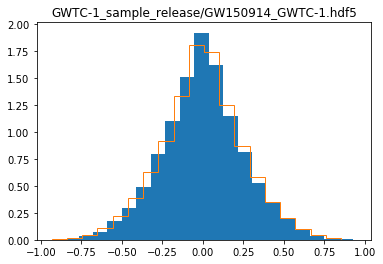

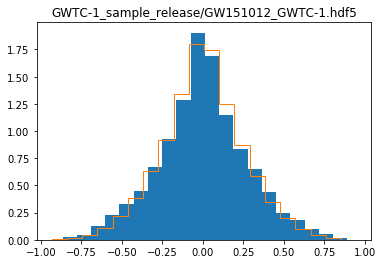

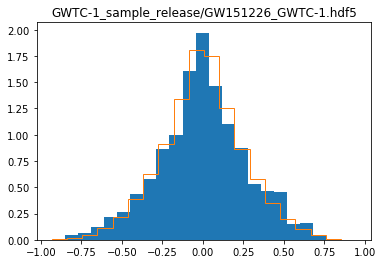

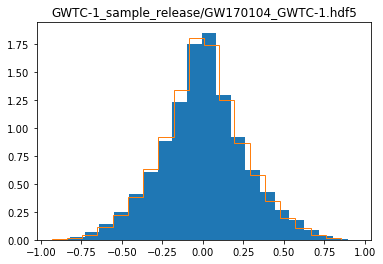

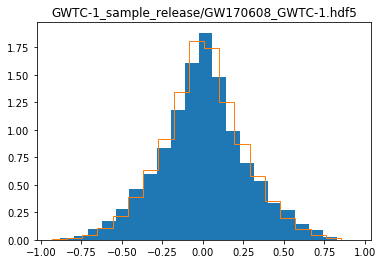

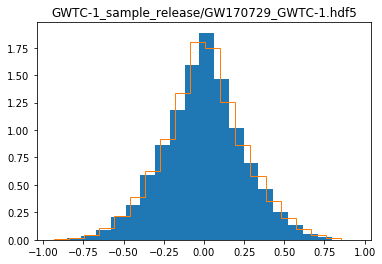

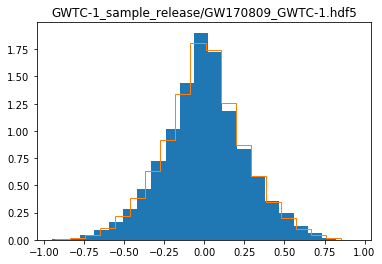

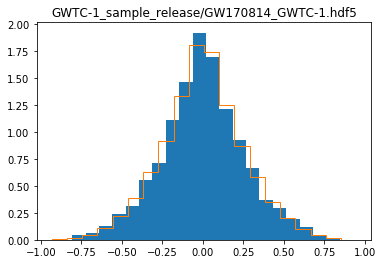

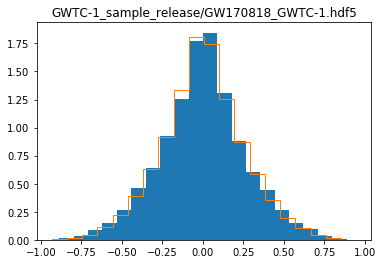

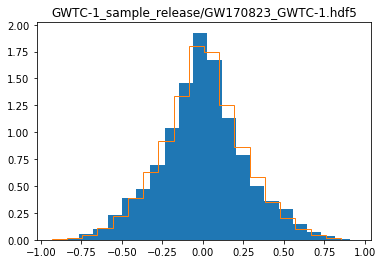

In [152]:
for h5file in glob.glob("GWTC-1_sample_release/GW??????_GWTC-1.hdf5"):
    if h5file=="GWTC-1_sample_release/GW170817_GWTC-1.hdf5":
        continue
    h5 = h5py.File(h5file)
    m1 = np.asarray(h5['prior'])['m1_detector_frame_Msun']
    m2 = np.asarray(h5['prior'])['m2_detector_frame_Msun']
    a1 = np.asarray(h5['prior'])['spin1']
    a2 = np.asarray(h5['prior'])['spin2']
    cost1 = np.asarray(h5['prior'])['costilt1']
    cost2 = np.asarray(h5['prior'])['costilt2']
    
    plt.hist(Calculate_Xeff(m1,m2,a1,a2,cost1,cost2),bins=20,density=True)
    plt.hist(xeff_prior_samps,bins=20,density=True,histtype='step')    
    
    plt.title(h5file)
    plt.show()

---

##### GW150914
##### GW151012
##### GW151226
##### GW170104
##### GW170608
##### GW170729
##### GW170809
##### GW170814
##### GW170818
##### GW170823


In [174]:
import pickle
with open('sampleDict_GWTC1_newPriors.pickle','wb') as testfile:
    pickle.dump(sampleDict,testfile,protocol=2)